In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

# Seaborn style settings
sns.set_theme(style="ticks", palette="mako")

In [2]:
master_df = pd.read_csv("data/2016_2021_master_df.csv")
master_df["DATE_PST"] = pd.to_datetime(master_df["DATE_PST"])
master_df.set_index("DATE_PST", inplace=True)
display(master_df.head())
print(master_df.shape)

,Vancouver_Clark_Drive_PM25,Vancouver_International_Airport_#2_PM25,North_Vancouver_Mahon_Park_PM25,North_Vancouver_Second_Narrows_PM25
DATE_PST,,,,
2016-01-01 01:00:00,30.557,22.71692,22.798870,NaN
2016-01-01 02:00:00,34.661,21.95020,22.909090,6.341111
2016-01-01 03:00:00,35.419,21.25953,19.857730,5.340278
2016-01-01 04:00:00,24.335,19.93333,13.575990,3.907917
2016-01-01 05:00:00,29.336,19.07922,7.079589,7.235889


(57014, 4)


In [3]:
# Melting
master_df = pd.melt(master_df,
                    value_vars=[
                    "Vancouver_Clark_Drive_PM25",\
                    "Vancouver_International_Airport_#2_PM25",\
                    "North_Vancouver_Mahon_Park_PM25",\
                    "North_Vancouver_Second_Narrows_PM25"
                    ],
                    ignore_index=False).rename(columns={
                    "variable": "Station",
                    "value": "PM 2.5"})
display(master_df.head())
print(master_df.shape)

,Station,PM 2.5
DATE_PST,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336


(228056, 2)


In [4]:
# Dummy variable to keep track of missing samples and missing sample length
master_df["MISSING"] = np.where(master_df["PM 2.5"].isnull(), 1, 0)
master_df.head()

,Station,PM 2.5,MISSING
DATE_PST,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0


In [5]:
# Total missing values
master_df["MISSING"].sum()

4958

In [6]:
# List of stations
stations = master_df["Station"].unique().tolist()
stations

['Vancouver_Clark_Drive_PM25',
 'Vancouver_International_Airport_#2_PM25',
 'North_Vancouver_Mahon_Park_PM25',
 'North_Vancouver_Second_Narrows_PM25']

In [7]:
# Isolating stations on independent dataframes
datasets = {}
for station in stations:
    datasets[station] = master_df[master_df["Station"] == station]
    datasets[station] = datasets[station][["PM 2.5", "MISSING"]]
    datasets[station].reset_index(inplace=True)

del master_df
datasets.keys()

dict_keys(['Vancouver_Clark_Drive_PM25', 'Vancouver_International_Airport_#2_PM25', 'North_Vancouver_Mahon_Park_PM25', 'North_Vancouver_Second_Narrows_PM25'])

In [8]:
# Identifying isolated missing values and continuous missing values
# Auxiliar column to identify missing value interval lengths
for station in stations:
    # Initialize missing value sequency array and maximum sequence length
    nan_seq_length = np.zeros(len(datasets[station]))
    seq_max = 0
    for i in range(0, len(datasets[station])):
        seq = 0  # Sequence counter
        if not datasets[station].loc[i, "MISSING"]:
            breakpoint = (
                i - 1
            )  # Store previous id when entering a missing value sequence
        while datasets[station].loc[i, "MISSING"]:
            i += 1  # Add up to iterator while still missing
            seq += 1  # Add up to sequence length while still missing
        if seq:  # Check if in a missing sequence
            if seq_max < seq:  # If max sequence length < current sequence
                seq_max = seq  # Update maximum sequence length
        else:
            seq_max = 0  # If not in a missing sequence reset max sequence lenght
        # Update sequence length array with maximum sequence length
        nan_seq_length[(i - seq)] = seq_max
    datasets[station]["MISSING_SEQ"] = nan_seq_length.astype(int)

In [9]:
# Recomposing Master DataFrame
master_df = pd.concat(datasets).reset_index(level=0)

# Renaming station column
master_df["STATION"] = master_df["level_0"]
master_df = master_df[["DATE_PST", "STATION", "PM 2.5", "MISSING", "MISSING_SEQ"]]
# master_df.drop("level_0", axis=1, inplace=True)

# Redefining DATE_PST index
master_df.set_index("DATE_PST", inplace=True)
master_df.head()

,STATION,PM 2.5,MISSING,MISSING_SEQ
DATE_PST,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0


### Thresholding missing sequence length
* Individual Missing Values (IMV)
* Continuous Missing Sample (CMS)

In [10]:
# Time threshold Tht
# MISSING_SEQ > Tht: Continuous missing samples (1)
# MISSING_SEQ <= Tht: Isolated missing value (0)
Tht = 6

master_df["MISSING_SAMPLE"] = np.where(master_df["MISSING_SEQ"] > Tht, 1, 0)
master_df.head()

,STATION,PM 2.5,MISSING,MISSING_SEQ,MISSING_SAMPLE
DATE_PST,,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0,0


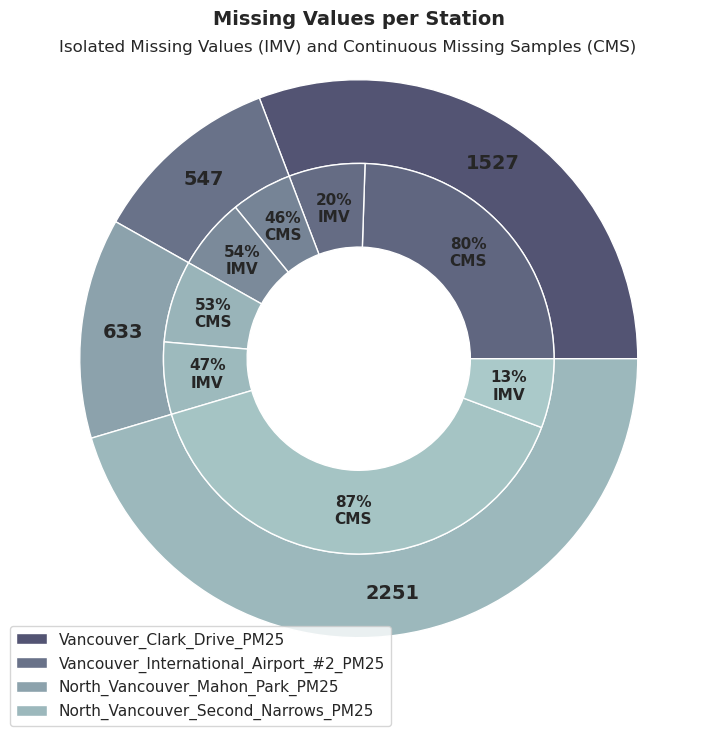

In [11]:
# Continuous missing samples // Isolated missing values count
stations = []
tot_missing = []
stations_cms_imv = []
stations_cms_imv_label = []

for station in pd.unique(master_df["STATION"]):
    stations.append(station)
    tot_missing_current = sum(master_df["MISSING"][master_df["STATION"] == station])
    tot_missing.append(tot_missing_current)
    tot_cms = sum(master_df["MISSING_SAMPLE"][master_df["STATION"] == station])
    stations_cms_imv.append(tot_cms)
    stations_cms_imv_label.append(f"{tot_cms/tot_missing_current * 100:.0f}%\nCMS")
    tot_imv = tot_missing_current - tot_cms
    stations_cms_imv.append(tot_imv)
    stations_cms_imv_label.append(f"{tot_imv/tot_missing_current * 100:.0f}%\nIMV")

# Stacked pie charts with IMV and CMS percentages
fig, ax = plt.subplots(figsize=(9, 9))
ax.axis("equal")
width = 0.3

cm = plt.get_cmap("bone")
cout = cm([95, 120, 160, 178])
pie, texts1 = ax.pie(
    tot_missing,
    radius=1,
    labels=tot_missing,
    colors=cout,
    labeldistance=0.85,
    textprops={"fontsize": 14, "weight": "bold"},
)
for t in texts1:
    t.set_horizontalalignment("center")
plt.legend(pie, stations, loc=(0, -0.03))
plt.setp(pie, width=width, edgecolor="white")

cin = cm(np.array([110, 115, 135, 140, 175, 180, 188, 193]))
pie2, texts2 = ax.pie(
    stations_cms_imv,
    radius=1 - width,
    labels=stations_cms_imv_label,
    labeldistance=0.78,
    colors=cin,
    textprops={"weight": "bold"},
)
for t in texts2:
    t.set_horizontalalignment("center")
plt.setp(pie2, width=width, edgecolor="white")
plt.title("Missing Values per Station", fontsize=14, weight="bold", y=0.97)
plt.suptitle(
    "Isolated Missing Values (IMV) and Continuous Missing Samples (CMS)",
    fontsize=12,
    y=0.85,
)
plt.show()

## Imputation of Missing Values
* IMV imputation with cubic spline and linear interpolation
* CMS imputation with LSTM

### Auxiliar Functions to search and plot IMV and CMS

In [12]:
master_df.head()

,STATION,PM 2.5,MISSING,MISSING_SEQ,MISSING_SAMPLE
DATE_PST,,,,,
2016-01-01 01:00:00,Vancouver_Clark_Drive_PM25,30.557,0,0,0
2016-01-01 02:00:00,Vancouver_Clark_Drive_PM25,34.661,0,0,0
2016-01-01 03:00:00,Vancouver_Clark_Drive_PM25,35.419,0,0,0
2016-01-01 04:00:00,Vancouver_Clark_Drive_PM25,24.335,0,0,0
2016-01-01 05:00:00,Vancouver_Clark_Drive_PM25,29.336,0,0,0


In [13]:
master_df["STATION"].unique()

array(['Vancouver_Clark_Drive_PM25',
       'Vancouver_International_Airport_#2_PM25',
       'North_Vancouver_Mahon_Park_PM25',
       'North_Vancouver_Second_Narrows_PM25'], dtype=object)

In [14]:
%load_ext autoreload
%autoreload 2
from tshelpers.subset import subset_interval, create_missing
from tshelpers.plot import plot_sequence, plot_compare
from tshelpers.metrics import rmse_score, mae_score

In [15]:
station_subset = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"]
interval = subset_interval(station_subset, missing_type="IMV", sequence_no=5)

179 IMV missing value sequences found with current arguments:
+-----+---------------------+---------------------+----------+
|     | Sequence Start      | Sequence End        | Length   |
|-----+---------------------+---------------------+----------|
|   0 | 2016-02-04 16:00:00 | 2016-02-04 17:00:00 | 1 h      |
|   1 | 2016-02-17 14:00:00 | 2016-02-17 15:00:00 | 1 h      |
|   2 | 2016-05-25 11:00:00 | 2016-05-25 13:00:00 | 2 h      |
|   3 | 2016-07-08 11:00:00 | 2016-07-08 12:00:00 | 1 h      |
|   4 | 2016-08-09 09:00:00 | 2016-08-09 13:00:00 | 4 h      |
|   5 | 2016-08-10 09:00:00 | 2016-08-10 14:00:00 | 5 h      |
|   6 | 2016-08-12 11:00:00 | 2016-08-12 14:00:00 | 3 h      |
|   7 | 2016-09-01 16:00:00 | 2016-09-01 18:00:00 | 2 h      |
|   8 | 2016-09-03 12:00:00 | 2016-09-03 14:00:00 | 2 h      |
|   9 | 2016-09-03 16:00:00 | 2016-09-03 17:00:00 | 1 h      |
|  10 | 2016-09-08 11:00:00 | 2016-09-08 13:00:00 | 2 h      |
|  11 | 2016-09-08 14:00:00 | 2016-09-08 15:00:00 | 1 h 

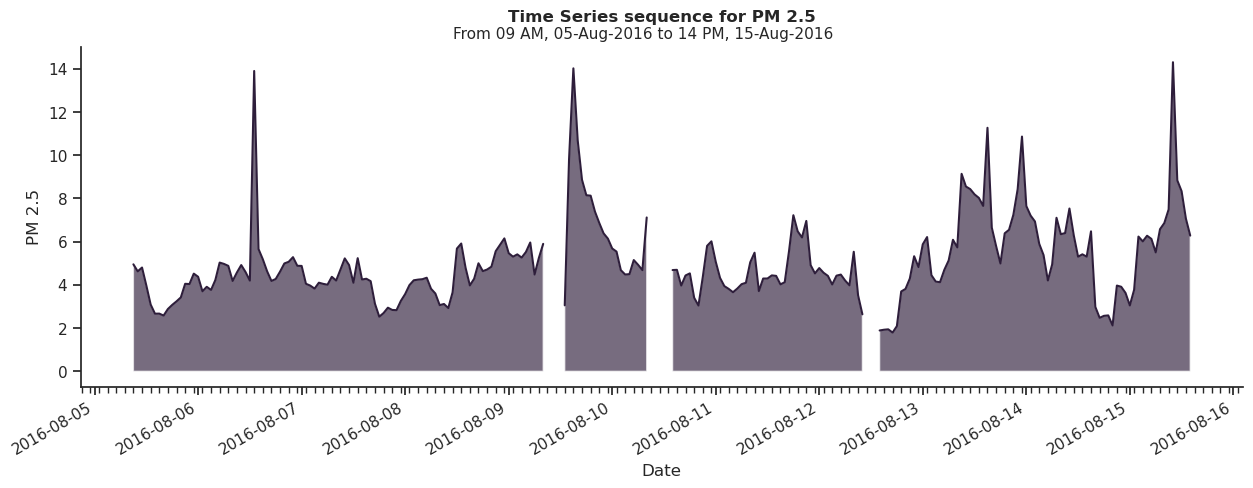

In [16]:
plot_sequence(data=station_subset, value="PM 2.5", start=interval[0], end=interval[1])

### Generating Artificial Missing Data
Artificially missing data will be generated to evaluate imputation methods.

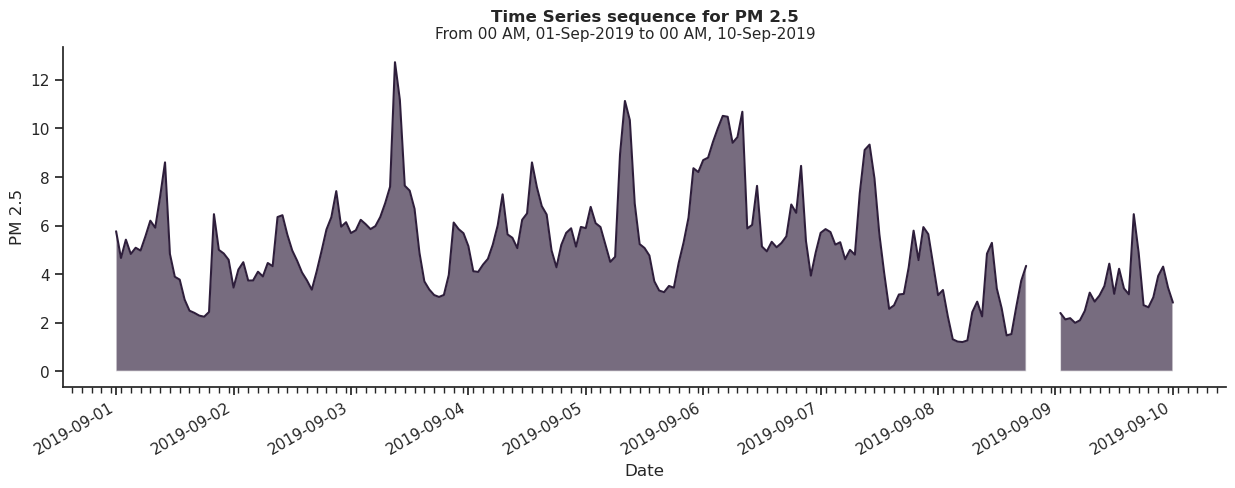

In [17]:
subset, subset_missing = create_missing(
    data=station_subset,
    value="PM 2.5",
    start=datetime(2019, 9, 1),
    end=datetime(2019, 9, 10),
    missing_length=6,
    padding=24,
    missing_index="end",
)

plot_sequence(data=subset_missing, value="PM 2.5")

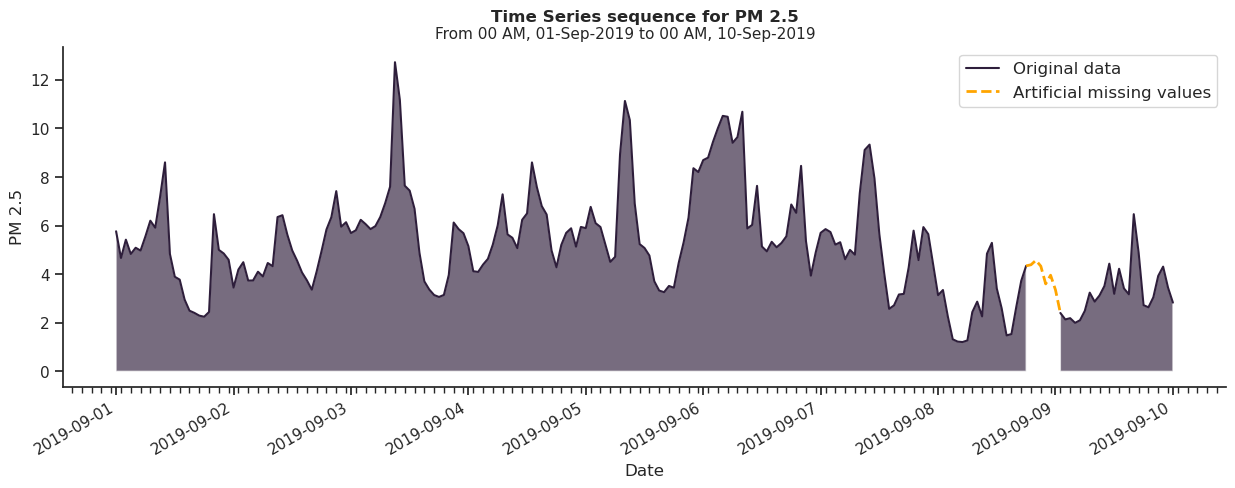

In [18]:
plot_compare(
    subset,
    subset_missing,
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    start=datetime(2019, 9, 1),
    end=datetime(2019, 9, 10),
    fill=True,
    data_label="Artificial missing values",
    data_missing_label="Original data",
)

## Imputation of short sequences [1h, 2h]
* Short sequences with 2 or less subsequent data points missing
* Testing between cubic spline and linear imputation

### Subsetting intervals for experimentation
Defining candidate subsets to experiment with imputation methods.

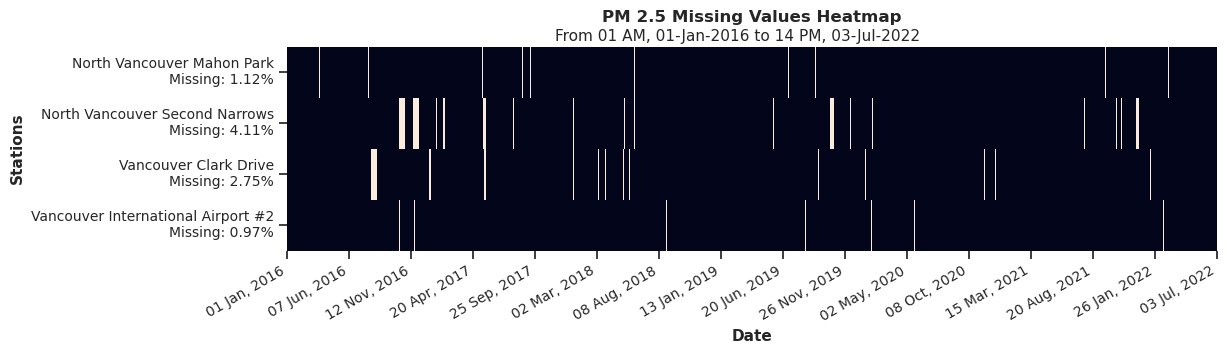

In [19]:
from tshelpers.plot import plot_missing
plot_missing(master_df.pivot(columns="STATION", values="PM 2.5"))

In [20]:
station_subset = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"]
interval = subset_interval(station_subset, missing_type="CMS", sequence_no=0)

20 CMS missing value sequences found with current arguments:
+----+---------------------+---------------------+----------+
|    | Sequence Start      | Sequence End        | Length   |
|----+---------------------+---------------------+----------|
|  0 | 2016-03-23 11:00:00 | 2016-03-24 01:00:00 | 14 h     |
|  1 | 2016-07-26 11:00:00 | 2016-07-27 00:00:00 | 13 h     |
|  2 | 2016-08-17 11:00:00 | 2016-08-18 14:00:00 | 27 h     |
|  3 | 2017-05-12 05:00:00 | 2017-05-14 19:00:00 | 62 h     |
|  4 | 2017-05-17 13:00:00 | 2017-05-18 12:00:00 | 23 h     |
|  5 | 2017-07-07 19:00:00 | 2017-07-08 10:00:00 | 15 h     |
|  6 | 2017-09-13 14:00:00 | 2017-09-13 21:00:00 | 7 h      |
|  7 | 2018-06-23 04:00:00 | 2018-06-23 13:00:00 | 9 h      |
|  8 | 2018-11-04 15:00:00 | 2018-11-05 03:00:00 | 12 h     |
|  9 | 2019-03-10 07:00:00 | 2019-03-10 15:00:00 | 8 h      |
| 10 | 2019-05-27 14:00:00 | 2019-05-28 05:00:00 | 15 h     |
| 11 | 2019-07-03 08:00:00 | 2019-07-05 00:00:00 | 40 h     |
| 12 | 20

In [21]:
# Looking for months without missing values
months_complete = {}
for station in stations:
    months_complete[station] = []
    station_subset = master_df[master_df["STATION"] == station]
    for year in range (2016, 2022):
        if year == 2022:
            range_max = 7
        else:
            range_max = 13
        for month in range(1, range_max):
            if month == 12:
                subset = station_subset[datetime(year, month, 1, 1): datetime(year, month, 31, 23)]
            else:
                subset = station_subset[datetime(year, month, 1, 1): datetime(year, month+1, 1)]
            if subset['PM 2.5'].isna().sum() == 0:
                # months_complete[station].append(f"{month}-{year}")
                months_complete[station].append((month, year))

for station in months_complete:
    print(f"{station} has {len(months_complete[station])} complete months:\n{months_complete[station]}\n")

Vancouver_Clark_Drive_PM25 has 3 complete months:
[(4, 2016), (10, 2016), (2, 2019)]

Vancouver_International_Airport_#2_PM25 has 3 complete months:
[(4, 2016), (7, 2016), (4, 2019)]

North_Vancouver_Mahon_Park_PM25 has 5 complete months:
[(1, 2016), (4, 2016), (6, 2016), (6, 2017), (2, 2018)]

North_Vancouver_Second_Narrows_PM25 has 9 complete months:
[(2, 2016), (6, 2016), (7, 2016), (3, 2017), (4, 2017), (9, 2017), (2, 2019), (4, 2019), (6, 2019)]



### Experimentation subsets
* Vancouver Clark Drive
    * 4-2016
    * 2-2019
* Vancouver International Airport:
    * 4-2016
    * 4-2019
* North Vancouver Mahon Park:
    * 6-2016
    * 6-2017
* North Vancouver Second Narrows:
    * 2-2016
    * 6-2016
    * 4-2017
    * 9-2017
    * 4-2019
    * 6-2019

In [22]:
# Experimental subsets
exp_subsets = {
    "Vancouver_Clark_Drive_PM25": {
        "4-2016": master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"][datetime(2016, 4, 1):datetime(2016, 5, 1)],
        "2-2019": master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"][datetime(2019, 2, 1):datetime(2019, 3, 1)],
    },
    "Vancouver_International_Airport_#2_PM25": {
        "4-2016": master_df[master_df["STATION"] == "Vancouver_International_Airport_#2_PM25"][datetime(2016, 4, 1):datetime(2016, 5, 1)],
        "4-2019": master_df[master_df["STATION"] == "Vancouver_International_Airport_#2_PM25"][datetime(2019, 4, 1):datetime(2019, 5, 1)],
    },
    "North_Vancouver_Mahon_Park_PM25": {
        "6-2016": master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"][datetime(2016, 6, 1):datetime(2016, 7, 1)],
        "6-2017": master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park_PM25"][datetime(2017, 6, 1):datetime(2017, 7, 1)],
    },
    "North_Vancouver_Second_Narrows_PM25": {
        "2-2016": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2016, 2, 1):datetime(2016, 3, 1)],
        "6-2016": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2016, 6, 1):datetime(2016, 7, 1)],
        "4-2017": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2017, 4, 1):datetime(2017, 5, 1)],
        "9-2017": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2017, 9, 1):datetime(2017, 10, 1)],
        "4-2019": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2019, 4, 1):datetime(2019, 5, 1)],
        "6-2019": master_df[master_df["STATION"] == "North_Vancouver_Second_Narrows_PM25"][datetime(2019, 6, 1):datetime(2019, 7, 1)],
    }
}

### Experimentation method
Backwards missing value generation.

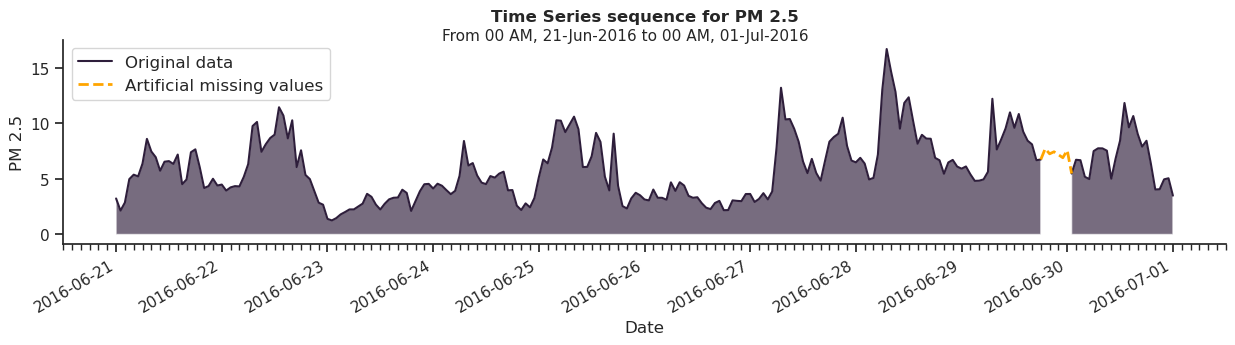

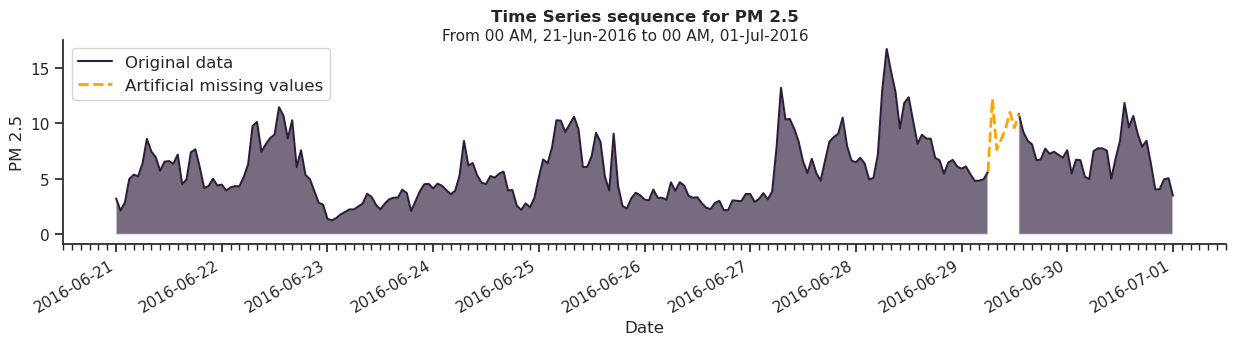

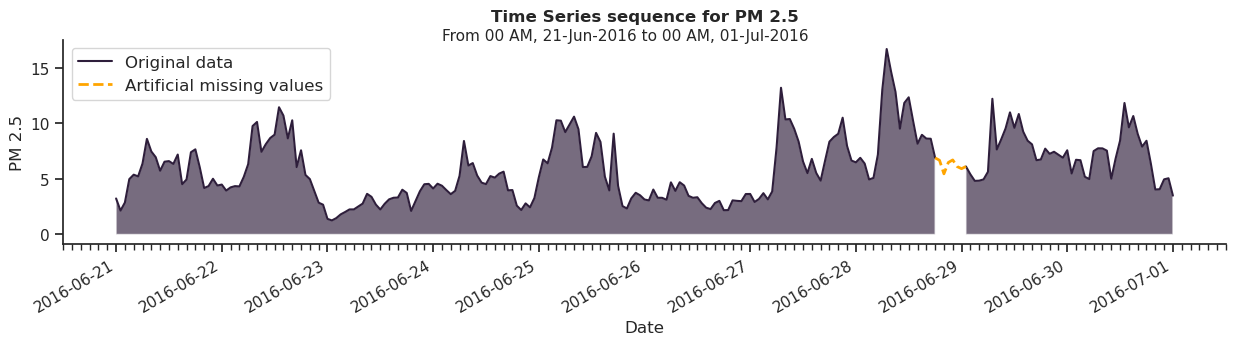

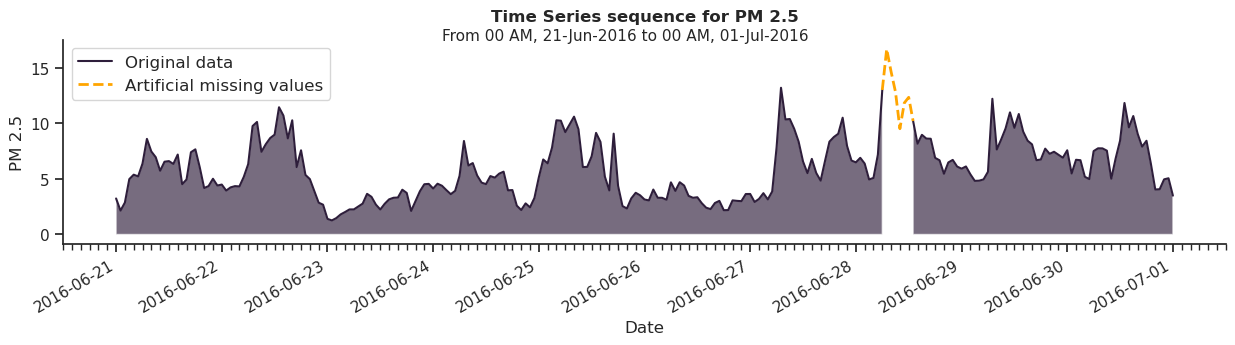

In [23]:
# Implementation example iterating through different paddings:
paddings = [24, 36, 48, 60]

for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )
    plot_compare(
        subset,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Artificial missing values",
        data_missing_label="Original data",
        figsize=(15, 3)
    )

Imputation example with linear interpolation.

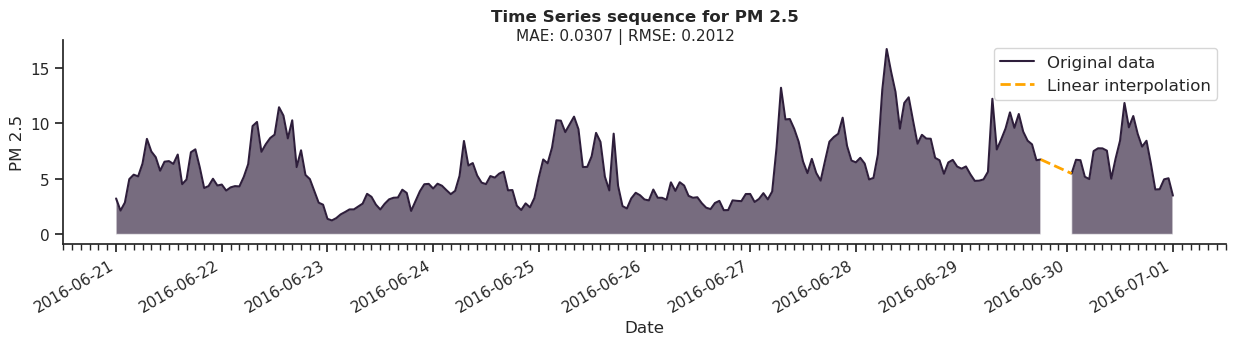

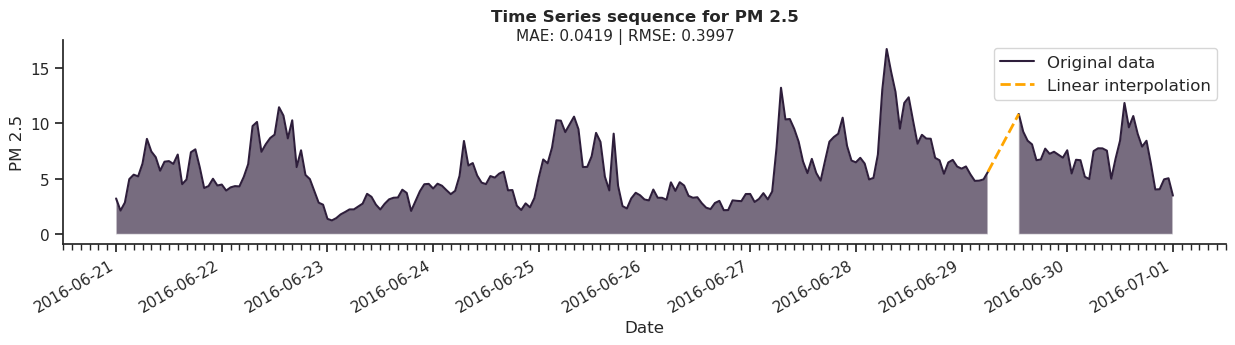

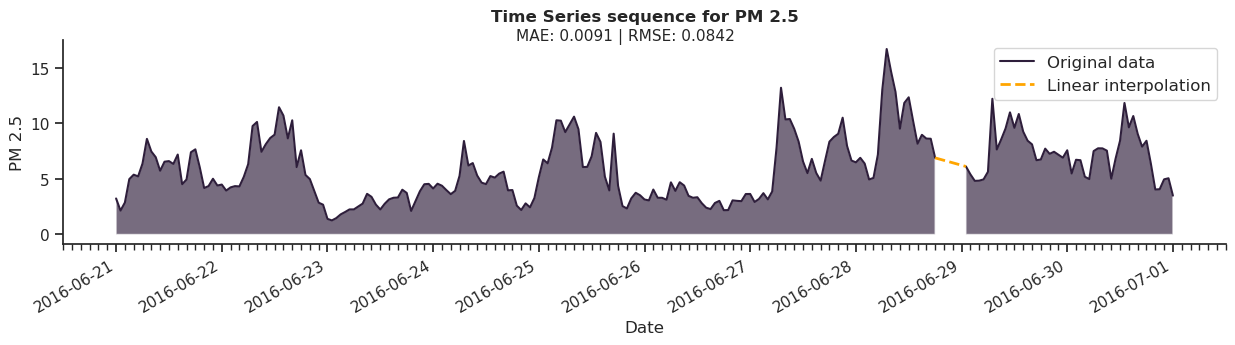

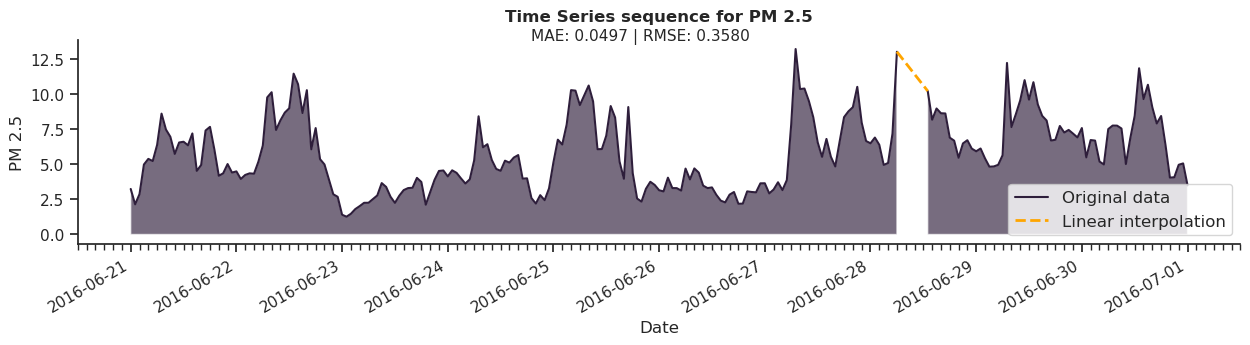

In [24]:
# Implementation example with linear interpolation:
for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )

    subset_linear = subset.copy()
    subset_linear["PM 2.5"] = (
        subset_missing["PM 2.5"].interpolate(method="linear").tolist()
    )
    
    plot_compare(
        subset_linear,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Linear interpolation",
        data_missing_label="Original data",
        plot_sup_title=f"MAE: {mae_score(subset, subset_linear, value='PM 2.5', verbose=False):.4f}\
 | RMSE: {rmse_score(subset, subset_linear, value='PM 2.5', verbose=False):.4f}",
        figsize=(15, 3)
    )

Imputation example with cubic spline.

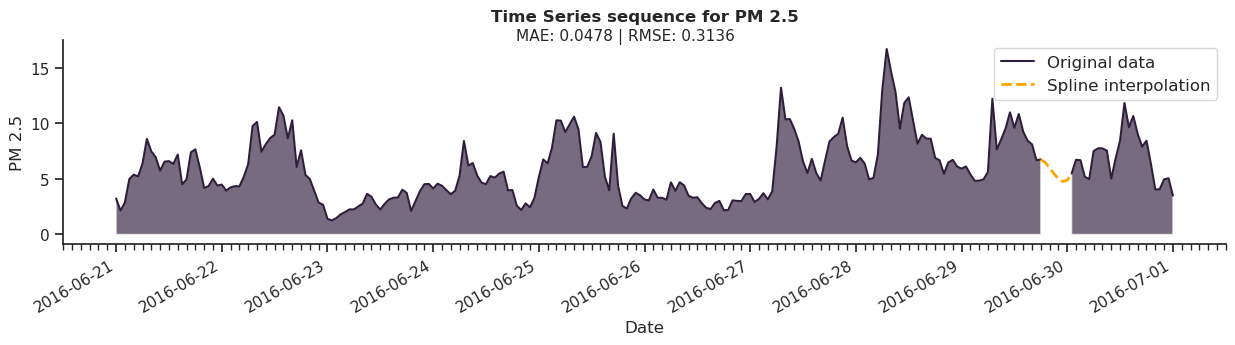

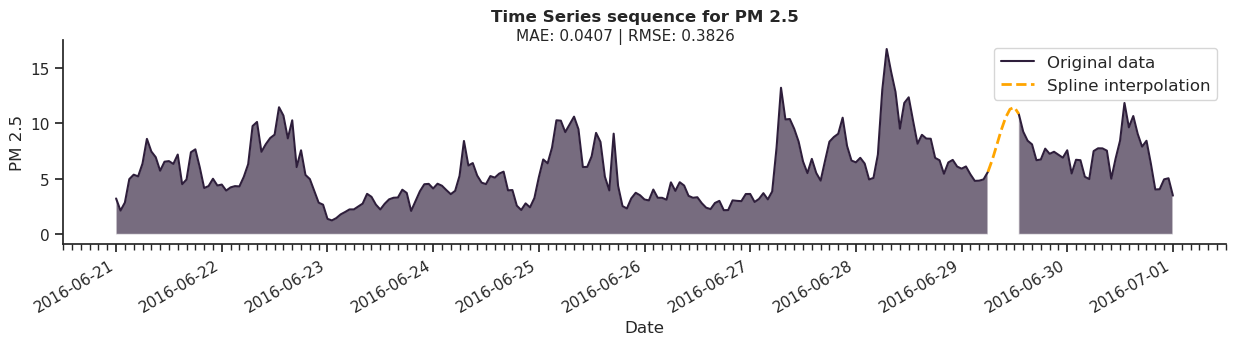

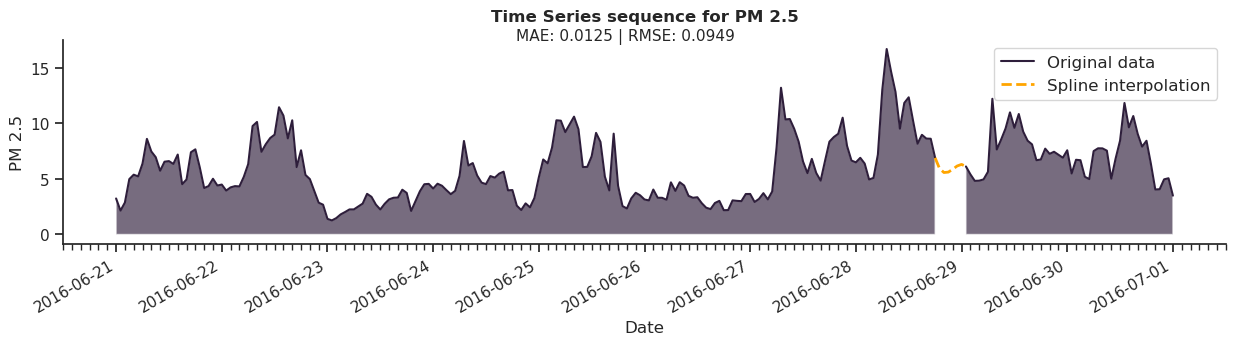

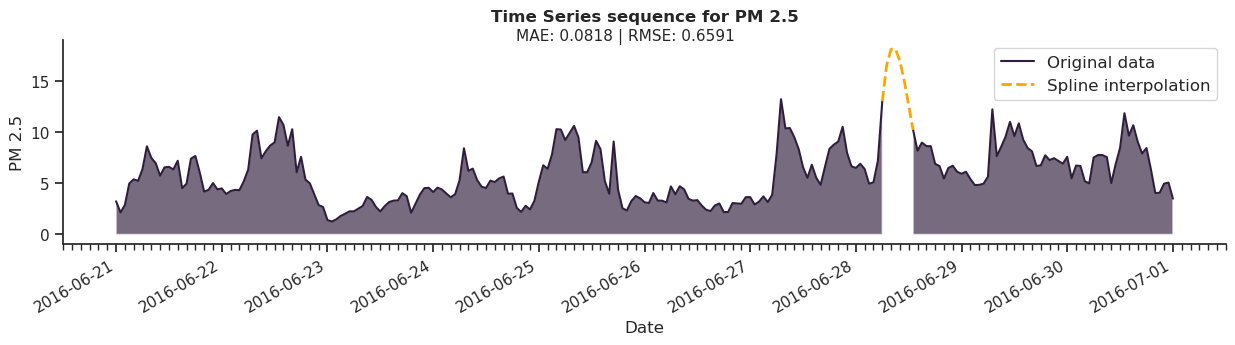

In [25]:
# Implementation example with spline interpolation:
pd.options.mode.chained_assignment = None
from scipy import interpolate

for padding in paddings:
    subset, subset_missing = create_missing(
        data=station_subset,
        value="PM 2.5",
        start=datetime(2016, 6, 21),
        end=datetime(2016, 7, 1),
        missing_length=6,
        padding=padding,
        missing_index="end",
    )

    subset_spline = subset.copy()
    # Indexing missing values
    missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

    # Indexing boundary values at t-2, t-1, t+1, and t+2
    boundary_idx = []
    for idx in range(min(missing_idx)-2, max(missing_idx)+3):
        if idx not in missing_idx:
            boundary_idx.append(idx)
    boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

    # Fitting cubic spline
    cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
    imputed = interpolate.splev(missing_idx, cubic_spline)

    subset_spline["PM 2.5"][missing_idx] = imputed

    plot_compare(
        subset_spline,
        subset_missing,
        value="PM 2.5",
        value_missing="PM 2.5",
        missing_only=True,
        data_label="Spline interpolation",
        data_missing_label="Original data",
        plot_sup_title=f"MAE: {mae_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}\
 | RMSE: {rmse_score(subset, subset_spline, value='PM 2.5', verbose=False):.4f}",
        figsize=(15, 3)
    )

>Ref.: _Carl de Boor, “A Practical Guide to Splines”, Springer-Verlag, 1978. pp 40-50_

### Linear and Cubic Spline imputation of Short Sequences
* Iteration through missing lengths ∈ (1h, 2h)
* For each subset, generate missing lengths on every hour, from right to left
* Measure Root-Mean-Square Error (RMSE) and Mean-Absolute Error (MAE) against original data

In [26]:
%%time
# Iterate through stations, then subsets to evaluate linear interpolation vs. cubic spline
from tqdm import tqdm

# Artificial missing values function parameters
create_missing_args = {
    "value": "PM 2.5",
    "missing_index": "end"
}

imputation_results = {}
for station in (pbar := tqdm(exp_subsets)):
    pbar.set_description(f"Processing station {station}")
    for station_subset in exp_subsets[station]:
        imputation_step = str(station + "_" + station_subset)
        imputation_results[imputation_step] = {}
        imputation_results[imputation_step]["RMSE_Cubic"] = []
        imputation_results[imputation_step]["RMSE_Linear"] = []
        imputation_results[imputation_step]["MAE_Cubic"] = []
        imputation_results[imputation_step]["MAE_Linear"] = []
        imputation_results[imputation_step]["Missing_Length"] = []        
        # Generating backwards missing intervals
        paddings = [i for i in range(2, len(exp_subsets[station][station_subset]))]
        for padding in paddings:
            # Creating missing interval with length = 1 and length = 2
            for length in [1, 2]:
                subset, subset_missing = create_missing(
                    **create_missing_args,
                    data=exp_subsets[station][station_subset],
                    padding=padding,
                    missing_length=length
                )
                ### Cubic spline
                subset_spline = subset.copy()
                missing_idx = np.where(subset_missing["PM 2.5"].isna())[0].tolist()

                # Indexing boundary values at t-2, t-1, t+1, and t+2
                boundary_idx = []
                for idx in range(min(missing_idx)-2, max(missing_idx)+3):
                    if idx not in missing_idx:
                        boundary_idx.append(idx)
                boundary = subset_missing["PM 2.5"][boundary_idx].tolist()

                # Fitting cubic spline
                cubic_spline = interpolate.splrep(x=boundary_idx, y=boundary, k=3)
                imputed = interpolate.splev(missing_idx, cubic_spline)
                subset_spline["PM 2.5"][missing_idx] = imputed

                # Evaluating cubic spline
                rmse_cubic = rmse_score(subset, subset_spline, value="PM 2.5", verbose=False)
                mae_cubic = mae_score(subset, subset_spline, value="PM 2.5", verbose=False)
                imputation_results[imputation_step]["RMSE_Cubic"].append(rmse_cubic)
                imputation_results[imputation_step]["MAE_Cubic"].append(mae_cubic)

                ### Linear interpolation
                subset_linear = subset.copy()
                subset_linear["PM 2.5"] = subset_missing["PM 2.5"].interpolate(method="linear", inplace=False).tolist()

                # Evaluating linear interpolation
                rmse_linear = rmse_score(subset, subset_linear, value="PM 2.5", verbose=False)
                mae_linear = mae_score(subset, subset_linear, value="PM 2.5", verbose=False)
                imputation_results[imputation_step]["RMSE_Linear"].append(rmse_linear)
                imputation_results[imputation_step]["MAE_Linear"].append(mae_linear)
                imputation_results[imputation_step]["Missing_Length"].append(length)

Processing station North_Vancouver_Second_Narrows_PM25: 100%|██████████| 4/4 [01:27<00:00, 21.93s/it]    

CPU times: user 1min 27s, sys: 0 ns, total: 1min 27s
Wall time: 1min 27s


In [27]:
# Concatenating master dataframe
subsets = []
for subset in imputation_results.keys():
    subsets.append(pd.DataFrame(imputation_results[subset]))

metrics_df = pd.concat(subsets).reset_index(drop=True)
metrics_df.round(6).head()

,RMSE_Cubic,RMSE_Linear,MAE_Cubic,MAE_Linear,Missing_Length
0,0.033493,0.024058,0.001247,0.000896,1
1,0.050441,0.051899,0.001883,0.002001,2
2,0.050351,0.050928,0.001875,0.001897,1
3,0.059907,0.051147,0.002644,0.001921,2
4,0.026684,0.025138,0.000994,0.000936,1


### RMSE and MAE results

In [28]:
metrics_df.groupby("Missing_Length").describe(percentiles=[]).T.round(5)

Missing_Length              1           2
RMSE_Cubic  count  8556.00000  8556.00000
            mean      0.03426     0.06690
            std       0.05219     0.08590
            min       0.00001     0.00024
            50%       0.01770     0.03985
            max       0.80107     1.29857
RMSE_Linear count  8556.00000  8556.00000
            mean      0.03296     0.06172
            std       0.05039     0.07897
            min       0.00000     0.00000
            50%       0.01714     0.03716
            max       0.78733     1.38782
MAE_Cubic   count  8556.00000  8556.00000
            mean      0.00128     0.00326
            std       0.00196     0.00423
            min       0.00000     0.00001
            50%       0.00066     0.00191
            max       0.03088     0.06828
MAE_Linear  count  8556.00000  8556.00000
            mean      0.00123     0.00299
            std       0.00189     0.00385
            min       0.00000     0.00000
            50%       0.00064     0.00180
            max       0.03002     0.07297

In [29]:
# Melting dataframes for boxplot visualizations
RMSE_melt_df = pd.melt(metrics_df[["RMSE_Cubic", "RMSE_Linear", "Missing_Length"]].rename(columns=lambda x: x.split("_")[1]),
                      id_vars="Length",
                      var_name="Method",
                      value_name="RMSE")

MAE_melt_df = pd.melt(metrics_df[["MAE_Cubic", "MAE_Linear", "Missing_Length"]].rename(columns=lambda x: x.split("_")[1]),
                      id_vars="Length",
                      var_name="Method",
                      value_name="MAE")

display(RMSE_melt_df.head())
print(RMSE_melt_df.shape)
display(MAE_melt_df.head())
print(MAE_melt_df.shape)

,Length,Method,RMSE
0,1,Cubic,0.033493
1,2,Cubic,0.050441
2,1,Cubic,0.050351
3,2,Cubic,0.059907
4,1,Cubic,0.026684


(34224, 3)


,Length,Method,MAE
0,1,Cubic,0.001247
1,2,Cubic,0.001883
2,1,Cubic,0.001875
3,2,Cubic,0.002644
4,1,Cubic,0.000994


(34224, 3)


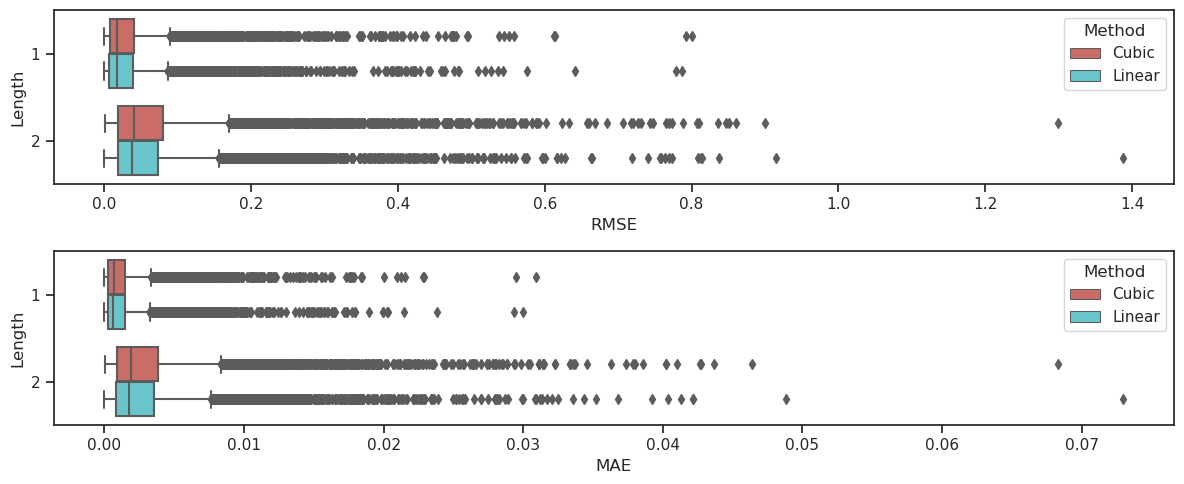

In [30]:
# Boxplot of metrics results
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
box_plot_args = {
    "y": "Length",
    "hue": "Method",
    "palette": "hls",
    "orient": "h"
}
sns.boxplot(RMSE_melt_df,
            x="RMSE",
            ax=axs[0],
            **box_plot_args)
sns.boxplot(MAE_melt_df,
            x="MAE",
            ax=axs[1],
            **box_plot_args)
fig.tight_layout()
plt.show()

RMSE metrics without outliers: (33501, 3). Outliers removed: 723.
MAE metrics without outliers: (33501, 3). Outliers removed: 723.


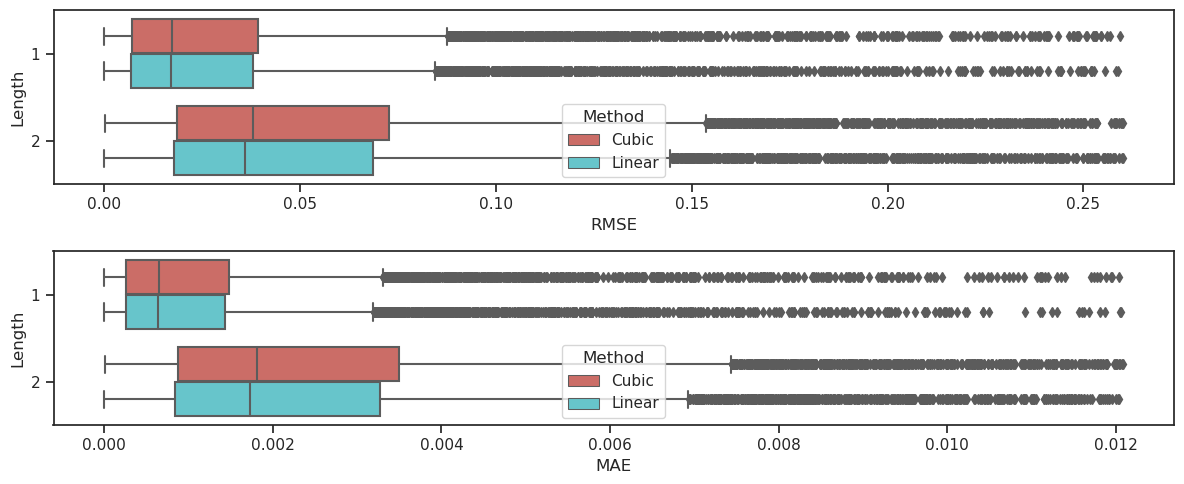

In [35]:
# Metrics without outliers
RMSE_melt_df_noout = RMSE_melt_df[(np.abs(stats.zscore(RMSE_melt_df["RMSE"])) < 3)]
MAE_melt_df_noout = MAE_melt_df[(np.abs(stats.zscore(MAE_melt_df["MAE"])) < 3)]
print(f"RMSE metrics without outliers: {RMSE_melt_df_noout.shape}.\
 Outliers removed: {MAE_melt_df.shape[0] - RMSE_melt_df_noout.shape[0]}.")
print(f"MAE metrics without outliers: {MAE_melt_df_noout.shape}.\
 Outliers removed: {MAE_melt_df.shape[0] - MAE_melt_df_noout.shape[0]}.")

# Boxplot of metrics results without outliers
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
sns.boxplot(RMSE_melt_df_noout,
            x="RMSE",
            ax=axs[0],
            **box_plot_args)
sns.boxplot(MAE_melt_df_noout,
            x="MAE",
            ax=axs[1],
            **box_plot_args)
fig.tight_layout()
plt.show()

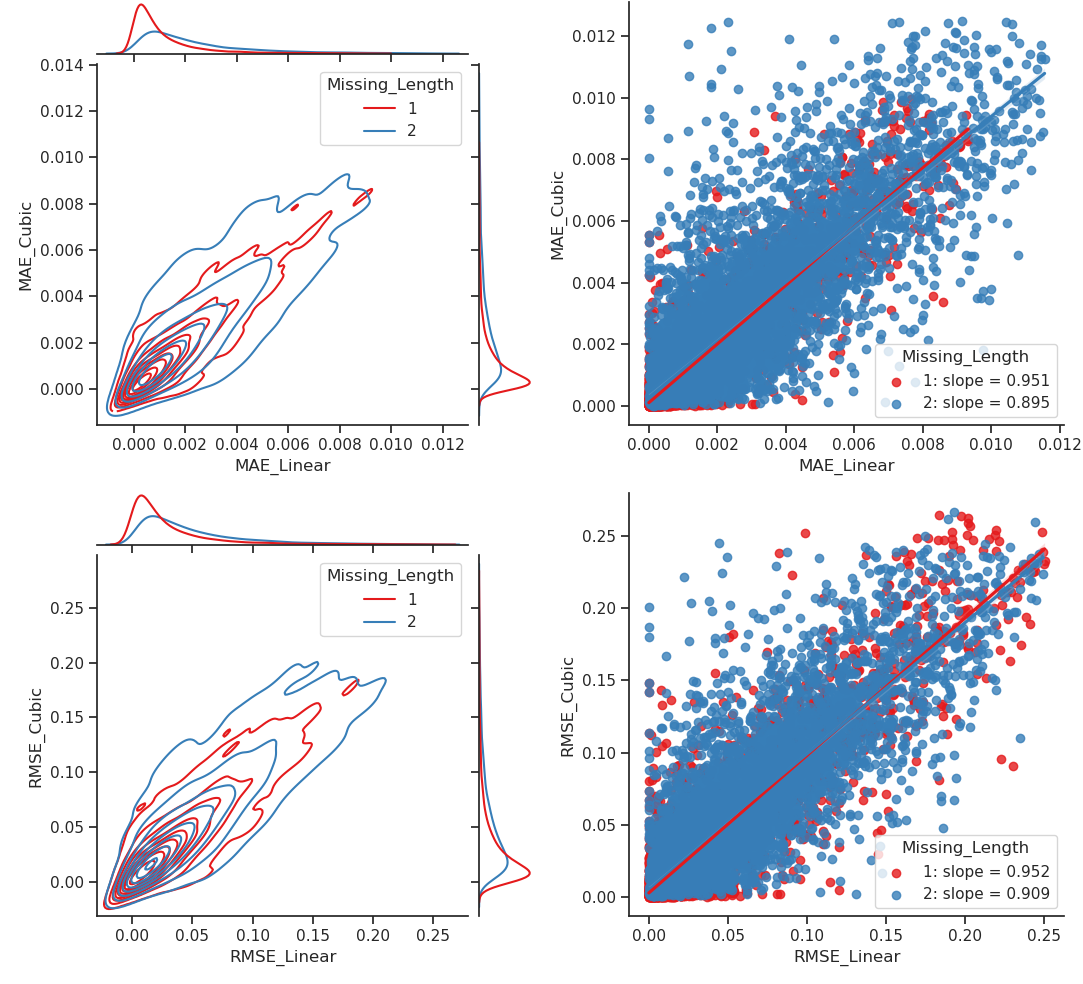

In [36]:
# Plotting pair and regression plots for 1h and 2h missing lengths
from tshelpers.plot import SeabornFig2Grid
from matplotlib import gridspec

# Metrics without outliers
metrics_df_noout = metrics_df[(np.abs(stats.zscore(metrics_df)) < 3).all(axis=1)]

# Regression slopes MAE
lr_mae_1 = stats.linregress(metrics_df_noout['MAE_Linear'][metrics_df_noout["Missing_Length"] == 1],
                      metrics_df_noout['MAE_Cubic'][metrics_df_noout["Missing_Length"] == 1])
lr_mae_2 = stats.linregress(metrics_df_noout['MAE_Linear'][metrics_df_noout["Missing_Length"] == 2],
                      metrics_df_noout['MAE_Cubic'][metrics_df_noout["Missing_Length"] == 2])
# Regression slopes RMSE
lr_rmse_1 = stats.linregress(metrics_df_noout['RMSE_Linear'][metrics_df_noout["Missing_Length"] == 1],
                      metrics_df_noout['RMSE_Cubic'][metrics_df_noout["Missing_Length"] == 1])
lr_rmse_2 = stats.linregress(metrics_df_noout['RMSE_Linear'][metrics_df_noout["Missing_Length"] == 2],
                      metrics_df_noout['RMSE_Cubic'][metrics_df_noout["Missing_Length"] == 2])

plot_args_mae = {
    "data": metrics_df_noout,
    "x": "MAE_Linear",
    "y": "MAE_Cubic",
    "hue": "Missing_Length",
    "palette": "Set1"
}
plot_args_rmse = {
    "data": metrics_df_noout,
    "x": "RMSE_Linear",
    "y": "RMSE_Cubic",
    "hue": "Missing_Length",
    "palette": "Set1"
}

# Joint and Regression plots
joint1 = sns.jointplot(**plot_args_mae,
              kind="kde")
lm1 = sns.lmplot(**plot_args_mae,
              legend_out=False)
ax = lm1.axes[0, 0]
leg1 = ax.get_legend()
L_labels1 = leg1.get_texts()
L_labels1[0].set_text(f"1: slope = {lr_mae_1.slope:.3f}")
L_labels1[1].set_text(f"2: slope = {lr_mae_2.slope:.3f}")

joint2 = sns.jointplot(**plot_args_rmse,
              kind="kde")
lm2 = sns.lmplot(**plot_args_rmse,
              legend_out=False)            
ax = lm2.axes[0, 0]
leg2 = ax.get_legend()
L_labels2 = leg2.get_texts()
L_labels2[0].set_text(f"1: slope = {lr_rmse_1.slope:.3f}")
L_labels2[1].set_text(f"2: slope = {lr_rmse_2.slope:.3f}")

# Figure plot grid
fig = plt.figure(figsize=(11, 10))
gs = gridspec.GridSpec(2, 2)

# Mapping subfigures to figure grid with SeabornFig2Grid
mg0 = SeabornFig2Grid(joint1, fig, gs[0])
mg1 = SeabornFig2Grid(lm1, fig, gs[1])
mg2 = SeabornFig2Grid(joint2, fig, gs[2])
mg3 = SeabornFig2Grid(lm2, fig, gs[3])
gs.tight_layout(fig)
plt.show()

### Test of statistical significance

In [37]:
# Shapiro-Wilk Test of normality
'''
H0: The sample is drawn from a normal distribution.
Ha: The sample is not drawn from a normal distribution.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
'''
for length in [1, 2]:
    for method in metrics_df.columns[:-1]:
        shap = stats.shapiro(metrics_df[method][metrics_df["Missing_Length"] == length])
        shap_p = shap.pvalue
        if shap_p > 0.05:
            print(f"Method {method} is normally distributed with p-value {shap_p:.9f}")
        else:
            print(f"Method {method} is not normally distributed with p-value {shap_p:.9f}")

Method RMSE_Cubic is not normally distributed with p-value 0.000000000
Method RMSE_Linear is not normally distributed with p-value 0.000000000
Method MAE_Cubic is not normally distributed with p-value 0.000000000
Method MAE_Linear is not normally distributed with p-value 0.000000000
Method RMSE_Cubic is not normally distributed with p-value 0.000000000
Method RMSE_Linear is not normally distributed with p-value 0.000000000
Method MAE_Cubic is not normally distributed with p-value 0.000000000
Method MAE_Linear is not normally distributed with p-value 0.000000000


In [38]:
# Wilcoxon signed-rank test for paired samples
'''
H0: Distribution of the differences between samples is symmetric about zero (Sample distributions are equal).
Ha: Distribution of the differences between samples is not symmetric about zero (Sample distributions are not equal).
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
'''
for length in [1, 2]:
    subset = metrics_df[metrics_df["Missing_Length"] == length]
    for metric in ["RMSE", "MAE"]:
        wilc = stats.wilcoxon(subset[f"{metric}_Cubic"], subset[f"{metric}_Linear"])
        wilc_p = wilc.pvalue
        if wilc_p > 0.05:
            print(f"{metric} metric is statistically equal between Cubic and Linear short sequence imputation\
 for {length}h length with p-value {wilc_p:.9f}")
        else:
            print(f"{metric} metric is statistically different between Cubic and Linear short sequence imputation\
 for {length}h length with p-value {wilc_p:.9f}")

RMSE metric is statistically different between Cubic and Linear short sequence imputation for 1h length with p-value 0.000000850
MAE metric is statistically different between Cubic and Linear short sequence imputation for 1h length with p-value 0.000000892
RMSE metric is statistically different between Cubic and Linear short sequence imputation for 2h length with p-value 0.000000000
MAE metric is statistically different between Cubic and Linear short sequence imputation for 2h length with p-value 0.000000000


### Imputing short sequences [1h, 2h]
* Imputation of short sequences up to 2h with linear method

In [39]:
station_subset = master_df[master_df["STATION"] == "Vancouver_Clark_Drive_PM25"]
interval = subset_interval(station_subset, missing_type="IMV", sequence_no=72, days_prior=10, days_later=10)

197 IMV missing value sequences found with current arguments:
+-----+---------------------+---------------------+----------+
|     | Sequence Start      | Sequence End        | Length   |
|-----+---------------------+---------------------+----------|
|   0 | 2016-01-05 09:00:00 | 2016-01-05 11:00:00 | 2 h      |
|   1 | 2016-01-06 10:00:00 | 2016-01-06 12:00:00 | 2 h      |
|   2 | 2016-02-02 14:00:00 | 2016-02-02 16:00:00 | 2 h      |
|   3 | 2016-03-13 03:00:00 | 2016-03-13 04:00:00 | 1 h      |
|   4 | 2016-03-24 11:00:00 | 2016-03-24 13:00:00 | 2 h      |
|   5 | 2016-05-26 15:00:00 | 2016-05-26 16:00:00 | 1 h      |
|   6 | 2016-06-23 09:00:00 | 2016-06-23 12:00:00 | 3 h      |
|   7 | 2016-07-07 17:00:00 | 2016-07-07 19:00:00 | 2 h      |
|   8 | 2016-08-19 13:00:00 | 2016-08-19 15:00:00 | 2 h      |
|   9 | 2016-08-22 06:00:00 | 2016-08-22 07:00:00 | 1 h      |
|  10 | 2016-09-02 09:00:00 | 2016-09-02 10:00:00 | 1 h      |
|  11 | 2016-09-22 04:00:00 | 2016-09-22 09:00:00 | 5 h 

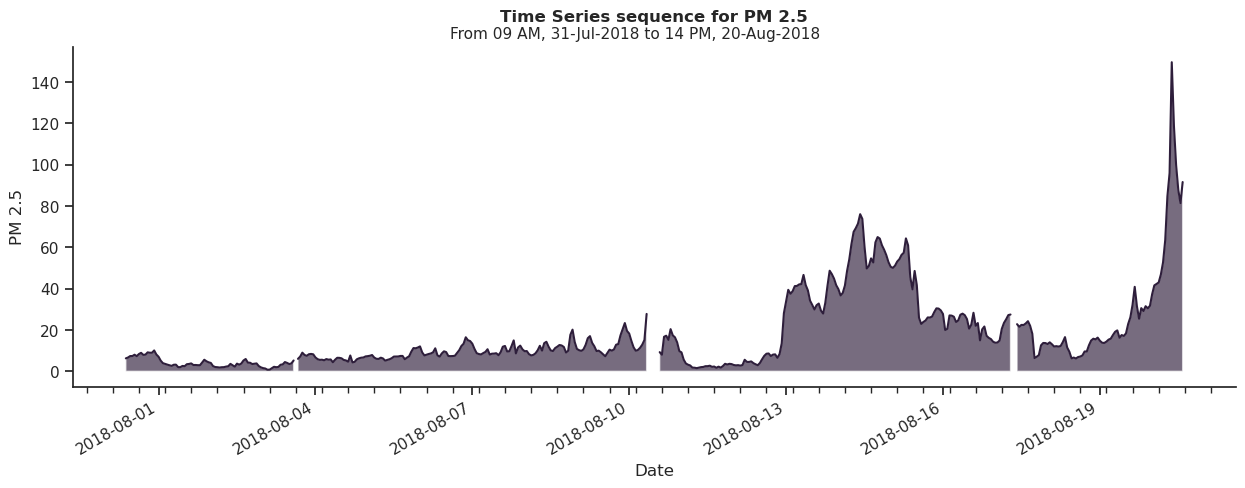

In [40]:
plot_sequence(data=station_subset, value="PM 2.5", start=interval[0], end=interval[1])

In [41]:
# Imputing short sequences missing values with linear interpolation
station_subset.loc[station_subset["MISSING_SEQ"] <= 2, "PM 2.5"] = station_subset.loc[station_subset["MISSING_SEQ"] <= 2, "PM 2.5"].interpolate()
station_subset.loc[station_subset["MISSING_SEQ"] <= 2, "PM 2.5"].isna().sum()

0

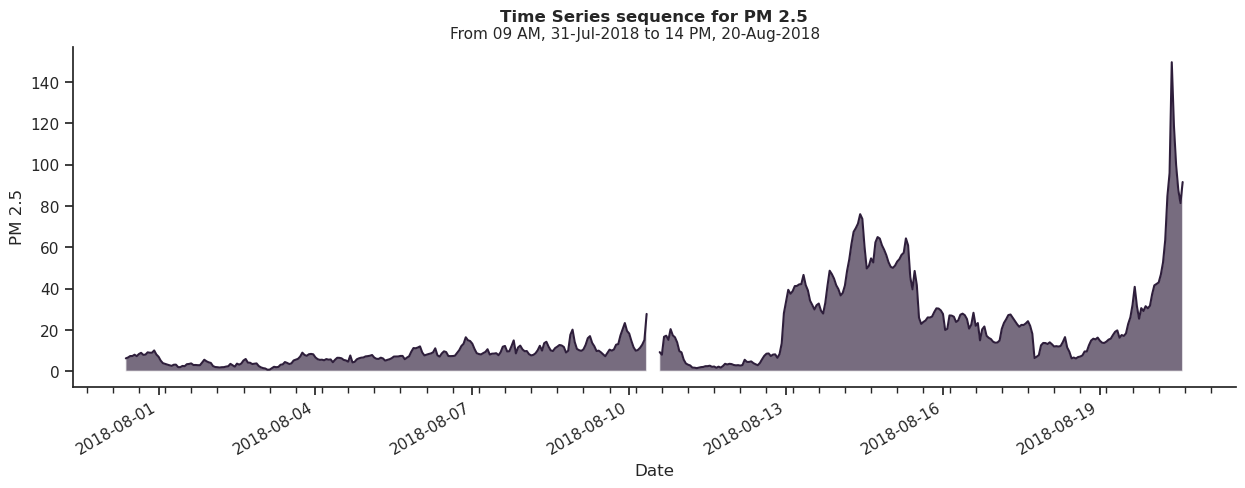

In [42]:
plot_sequence(data=station_subset, value="PM 2.5", start=interval[0], end=interval[1])

,Missing,Missing %
STATION,0,0.00
PM 2.5,4958,2.22
MISSING,0,0.00
MISSING_SEQ,0,0.00
MISSING_SAMPLE,0,0.00


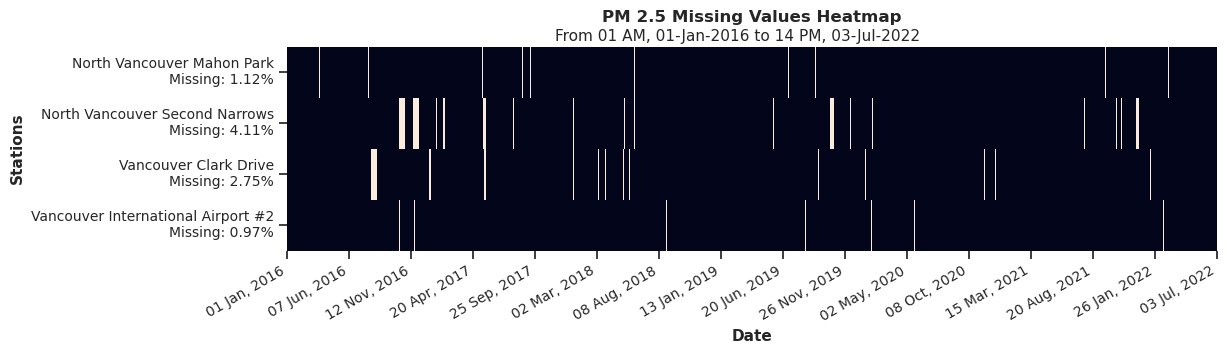

In [43]:
# Missing summary before linear interpolation imputation
missing_tot = master_df.isna().sum()
missing_pct = round(master_df.isna().sum()/master_df.count()*100, 2)
missing_summary = pd.concat([missing_tot, missing_pct], axis=1)
missing_summary.rename(columns={0: 'Missing', 1: 'Missing %'}, inplace=True)
display(missing_summary)

plot_missing(master_df.pivot(columns="STATION", values="PM 2.5"))

,Missing,Missing %
STATION,0,0.00
PM 2.5,4175,1.86
MISSING,0,0.00
MISSING_SEQ,0,0.00
MISSING_SAMPLE,0,0.00


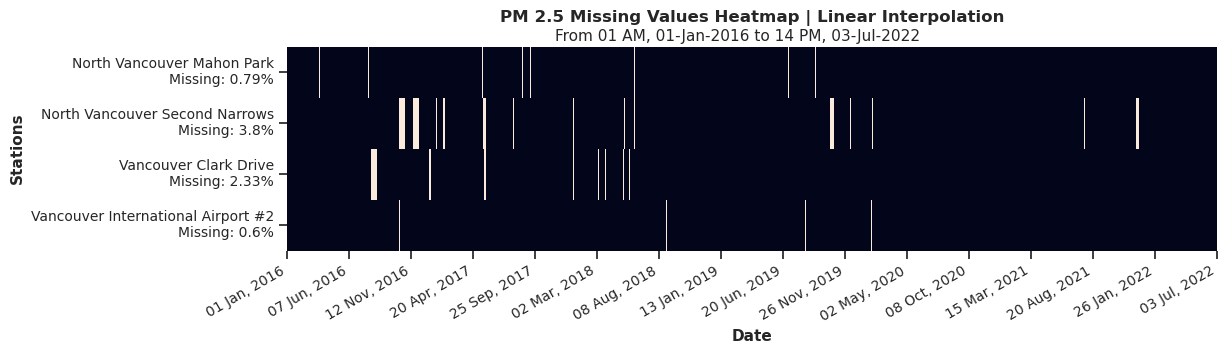

In [44]:
# Linear interpolation imputation
master_df.loc[master_df["MISSING_SEQ"] <= 2, "PM 2.5"] = master_df.loc[master_df["MISSING_SEQ"] <= 2, "PM 2.5"].interpolate()

# Missing summary
missing_tot = master_df.isna().sum()
missing_pct = round(master_df.isna().sum()/master_df.count()*100, 2)
missing_summary = pd.concat([missing_tot, missing_pct], axis=1)
missing_summary.rename(columns={0: 'Missing', 1: 'Missing %'}, inplace=True)
display(missing_summary)

plot_missing(master_df.pivot(columns="STATION", values="PM 2.5"), plot_title="PM 2.5 Missing Values Heatmap | Linear Interpolation")

In [47]:
master_df.to_csv("data/2016_2021_master_df_short_imputed.csv")

## Imputation of short sequences (2h, 6h]
* Short sequences with 3 to 6 subsequent data points missing
* Testing ARIMA model

In [41]:
# Looking for months without missing values
months_complete = {}
for station in stations:
    months_complete[station] = []
    station_subset = master_df[master_df["STATION"] == station]
    for year in range (2016, 2022):
        if year == 2022:
            range_max = 7
        else:
            range_max = 13
        for month in range(1, range_max):
            if month == 12:
                subset = station_subset[datetime(year, month, 1, 1): datetime(year, month, 31, 23)]
            else:
                subset = station_subset[datetime(year, month, 1, 1): datetime(year, month+1, 1)]
            if subset['PM 2.5'].isna().sum() == 0:
                # months_complete[station].append(f"{month}-{year}")
                months_complete[station].append((month, year))

for station in months_complete:
    print(f"{station} has {len(months_complete[station])} complete months:\n{months_complete[station]}\n")

Vancouver_Clark_Drive_PM25 has 42 complete months:
[(2, 2016), (3, 2016), (4, 2016), (7, 2016), (10, 2016), (6, 2017), (7, 2017), (11, 2017), (2, 2018), (4, 2018), (6, 2018), (7, 2018), (9, 2018), (10, 2018), (12, 2018), (1, 2019), (2, 2019), (3, 2019), (6, 2019), (7, 2019), (9, 2019), (10, 2019), (11, 2019), (12, 2019), (1, 2020), (2, 2020), (3, 2020), (4, 2020), (5, 2020), (6, 2020), (7, 2020), (8, 2020), (10, 2020), (11, 2020), (12, 2020), (1, 2021), (4, 2021), (7, 2021), (8, 2021), (9, 2021), (10, 2021), (12, 2021)]

Vancouver_International_Airport_#2_PM25 has 46 complete months:
[(1, 2016), (2, 2016), (3, 2016), (4, 2016), (5, 2016), (7, 2016), (8, 2016), (9, 2016), (11, 2016), (12, 2016), (1, 2017), (4, 2017), (5, 2017), (7, 2017), (8, 2017), (9, 2017), (10, 2017), (11, 2017), (2, 2018), (3, 2018), (5, 2018), (9, 2018), (10, 2018), (11, 2018), (1, 2019), (2, 2019), (4, 2019), (7, 2019), (9, 2019), (10, 2019), (12, 2019), (3, 2020), (4, 2020), (5, 2020), (6, 2020), (7, 2020), (8, 

### Fitting to one month training set

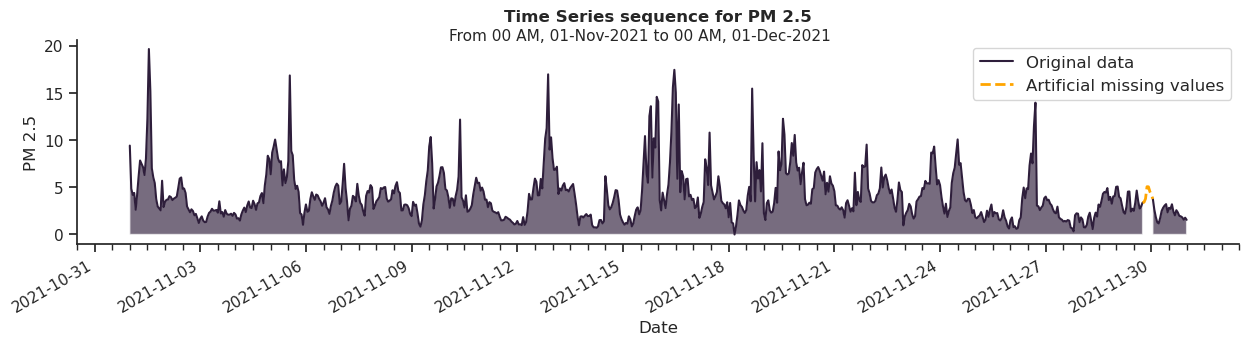

In [42]:
# Experimental subset
station_subset_2021_11 = station_subset[datetime(2021, 11, 1):datetime(2021, 12, 1)]
missing_length = 6
padding = 24

subset, subset_missing = create_missing(
    data=station_subset_2021_11,
    value="PM 2.5",
    missing_length=missing_length,
    padding=padding,
    missing_index="end",
)
plot_compare(
    subset,
    subset_missing,
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    data_label="Artificial missing values",
    data_missing_label="Original data",
    figsize=(15, 3)
)

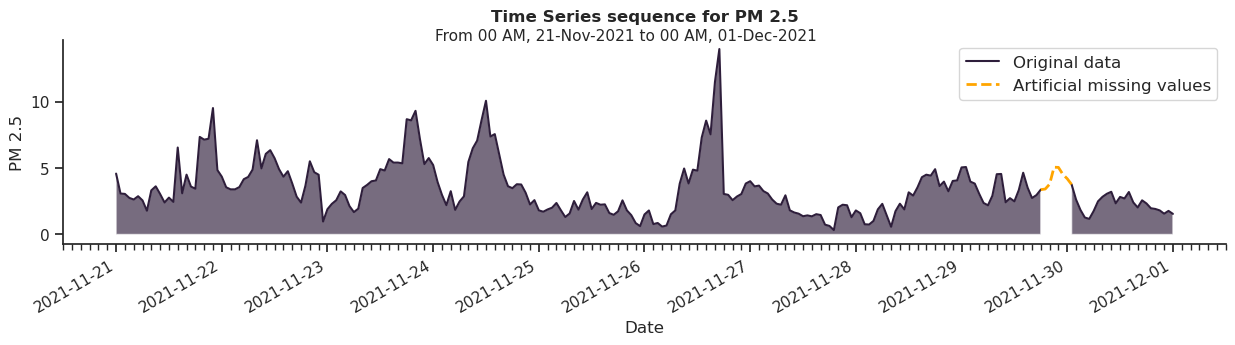

In [43]:
# Closer view
plot_compare(
    subset,
    subset_missing,
    start=datetime(2021, 11, 21),
    end=datetime(2021, 12, 1),
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    data_label="Artificial missing values",
    data_missing_label="Original data",
    figsize=(15, 3)
)

In [44]:
# Testing stationarity on example period
from tshelpers.metrics import stationarity_test

stationarity_test(subset, value = "PM 2.5")

,adf,kpss
Test Statistic,-8.3202,0.2354
p-value,0.0,0.1
Lags Used,1,15
Decision,Stationary,Stationary


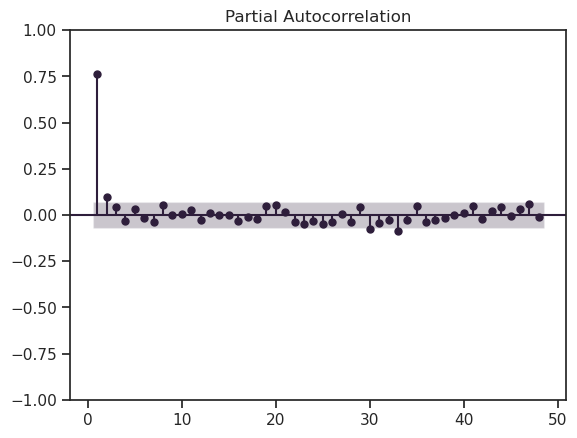

In [45]:
# Autocorrelation and Partial Autocorrelation on example period
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_pacf(subset["PM 2.5"],
          lags=48,
          method="yw",
          zero=False)
plt.show()

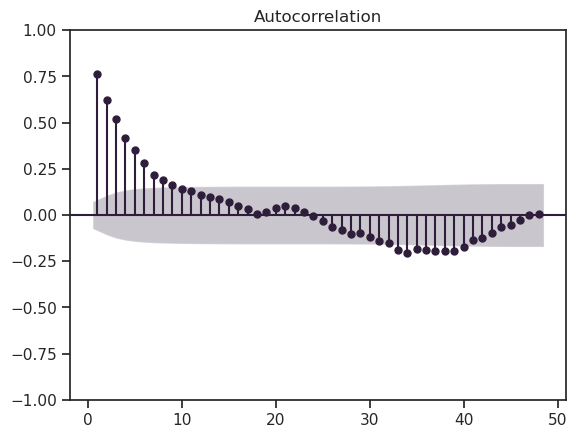

In [46]:
plot_acf(subset["PM 2.5"],
         lags=48,
         zero=False)
plt.show()

In [47]:
# Seasonal ARIMA step-wise grid search
import pmdarima as pm
from pmdarima.arima.utils import nsdiffs

# Test size to forecast missing length onwards
test_size = padding + missing_length

train, test = pm.model_selection.train_test_split(subset["PM 2.5"], test_size=test_size)
print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

Train: (691,)
Test: (30,)


In [48]:
# Seasonal ARIMA model
auto_sarima = pm.auto_arima(train,
                           seasonal=True,
                           m=6,
                           test="adf",
                           stepwise=True,
                           trace=True)

auto_sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=2758.198, Time=2.35 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=3352.795, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=2757.062, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=2969.228, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=4189.357, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[6] intercept   : AIC=2756.312, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[6] intercept   : AIC=2757.023, Time=0.31 sec
 ARIMA(1,0,0)(1,0,1)[6] intercept   : AIC=2759.000, Time=0.86 sec
 ARIMA(2,0,0)(0,0,0)[6] intercept   : AIC=2752.359, Time=0.13 sec
 ARIMA(2,0,0)(1,0,0)[6] intercept   : AIC=2753.897, Time=0.41 sec
 ARIMA(2,0,0)(0,0,1)[6] intercept   : AIC=2753.879, Time=0.37 sec
 ARIMA(2,0,0)(1,0,1)[6] intercept   : AIC=2755.986, Time=0.91 sec
 ARIMA(3,0,0)(0,0,0)[6] intercept   : AIC=2753.180, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[6] intercept   : AIC=2753.651, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[6] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  691
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1371.917
Date:                Wed, 02 Nov 2022   AIC                           2751.834
Time:                        16:34:55   BIC                           2769.987
Sample:                    11-01-2021   HQIC                          2758.856
                         - 11-29-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7745      0.161      4.799      0.000       0.458       1.091
ar.L1          0.8165      0.021     39.141      0.000       0.776       0.857
ma.L1         -0.1309      0.029     -4.545      0.000      -0.187      -0.074
sigma2         3.1008      0.082     37.603      0.000       2.939       3.262
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2640.44
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
# Forecasting missing interval
forecast = auto_sarima.predict(n_periods=test_size)

print("Original sequence:")
display(subset.loc[forecast.index[:missing_length], "PM 2.5"])
print("Predicted sequence:")
display(forecast[:missing_length])

Original sequence:


2021-11-29 19:00:00    3.419275
2021-11-29 20:00:00    3.786819
2021-11-29 21:00:00    5.062339
2021-11-29 22:00:00    5.050550
2021-11-29 23:00:00    4.529205
2021-11-30 00:00:00    4.198236
Name: PM 2.5, dtype: float64

Predicted sequence:


2021-11-29 19:00:00    3.512011
2021-11-29 20:00:00    3.642142
2021-11-29 21:00:00    3.748397
2021-11-29 22:00:00    3.835155
2021-11-29 23:00:00    3.905995
2021-11-30 00:00:00    3.963836
Freq: H, dtype: float64

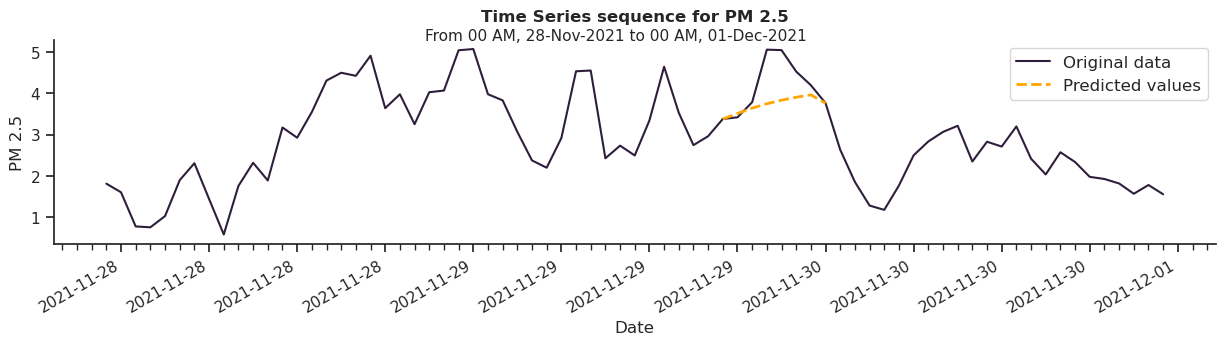

In [50]:
# Visualizing predicted interval
predicted = subset.copy()
predicted.loc[forecast.index[:missing_length], "PM 2.5"] = forecast[:missing_length]

plot_compare(
    predicted,
    subset,
    missing_range=subset_missing,
    start=datetime(2021, 11, 28),
    end=datetime(2021, 12, 1),
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    data_label="Predicted values",
    data_missing_label="Original data",
    figsize=(15, 3),
    fill=False
)

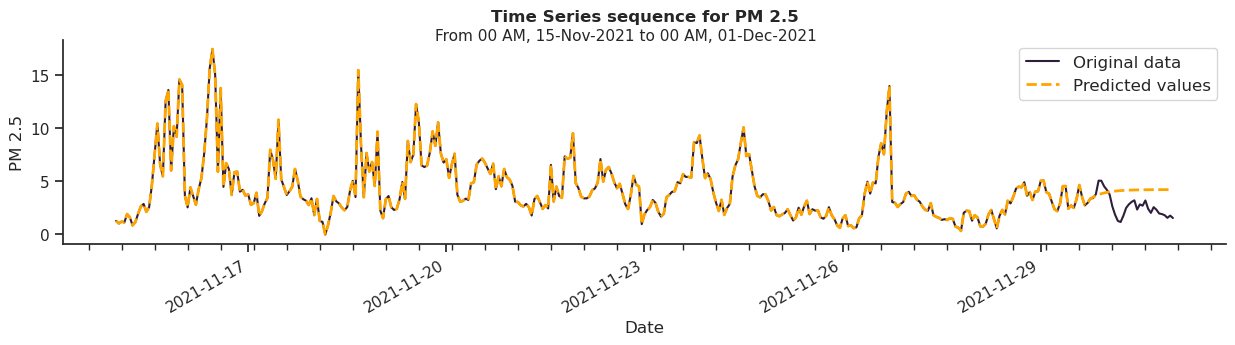

In [51]:
# Visualizing predicted interval over complete test span
predicted = subset.copy()
predicted.loc[forecast.index, "PM 2.5"] = forecast

plot_compare(
    predicted,
    subset,
    # missing_range=subset_missing,
    start=datetime(2021, 11, 15),
    end=datetime(2021, 12, 1),
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=False,
    data_label="Predicted values",
    data_missing_label="Original data",
    figsize=(15, 3),
    fill=False
)

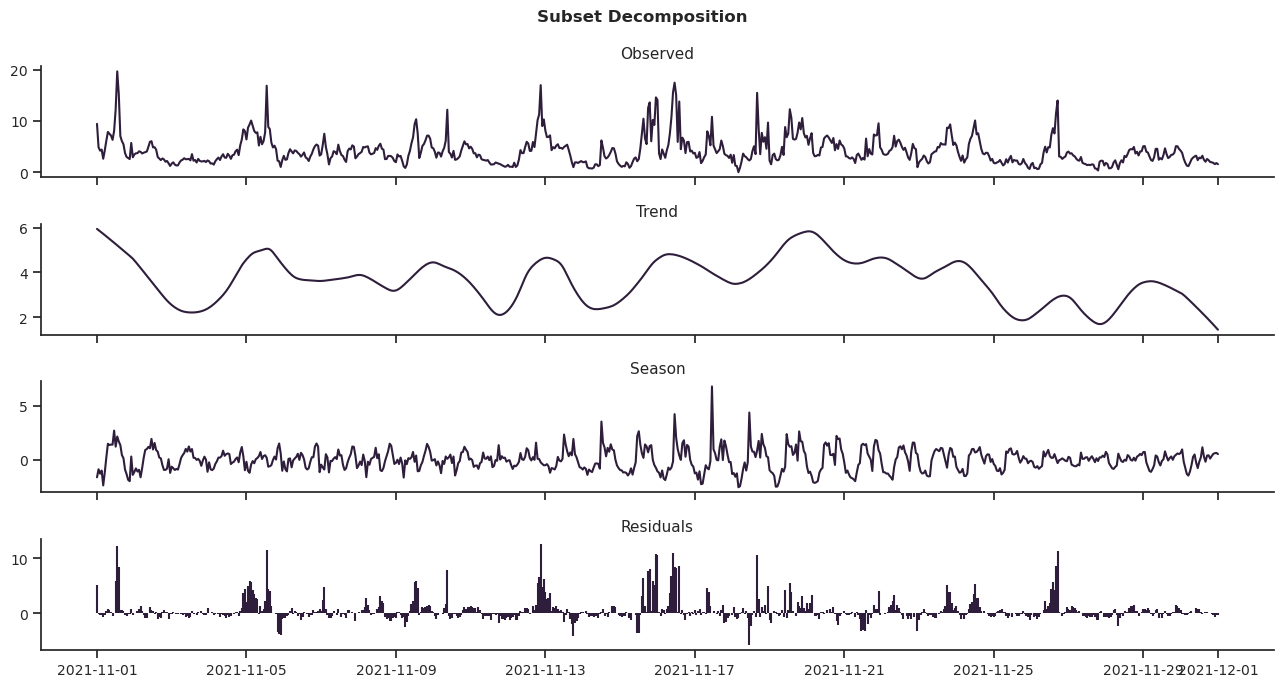

In [52]:
# Seasonal decomposition
from statsmodels.tsa.seasonal import STL

decomposed = STL(subset["PM 2.5"],
                 seasonal=7,
                 robust=True).fit()

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(13, 7))
ax[0].plot(decomposed.observed)
ax[0].set_title("Observed", fontsize=11)
ax[0].tick_params(labelsize=10)

ax[1].plot(decomposed.trend)
ax[1].set_title("Trend", fontsize=11)
ax[1].tick_params(labelsize=10)

ax[2].plot(decomposed.seasonal)
ax[2].set_title("Season", fontsize=11)
ax[2].tick_params(labelsize=10)

_, stls, _ = ax[3].stem(decomposed.resid.index,
                        decomposed.resid,
                        markerfmt=' ',
                        basefmt=' ')
plt.setp(stls, 'linewidth', 1.5)
ax[3].set_title("Residuals", fontsize=11)
ax[3].tick_params(labelsize=10)
plt.suptitle("Subset Decomposition", fontsize=12, fontweight="bold")
sns.despine()
plt.tight_layout()

### Fitting to bi-week training set

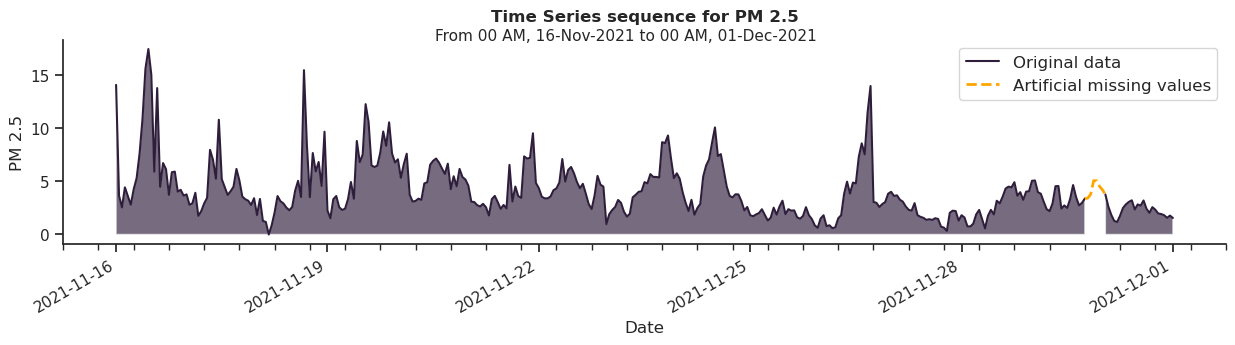

In [53]:
# Experimental subset
station_subset_2021_11_16 = station_subset[datetime(2021, 11, 16):datetime(2021, 12, 1)]
missing_length = 6
padding = 24

subset, subset_missing = create_missing(
    data=station_subset_2021_11_16,
    value="PM 2.5",
    missing_length=missing_length,
    padding=padding,
    missing_index="end",
)
plot_compare(
    subset,
    subset_missing,
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    data_label="Artificial missing values",
    data_missing_label="Original data",
    figsize=(15, 3)
)

In [54]:
# Testing stationarity on example period
stationarity_test(subset, value = "PM 2.5")

,adf,kpss
Test Statistic,-5.6485,1.0552
p-value,0.0,0.01
Lags Used,3,10
Decision,Stationary,Non-Stationary


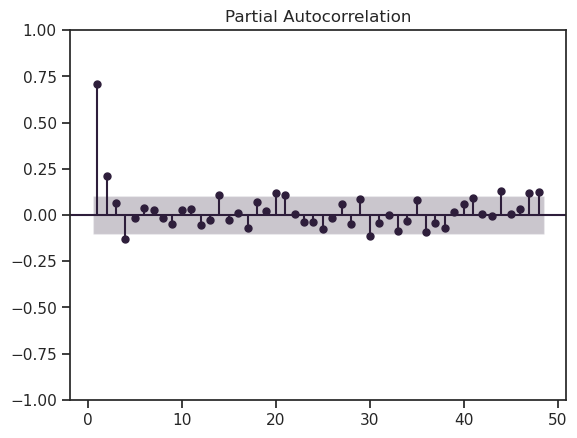

In [55]:
# Autocorrelation and Partial Autocorrelation on example period
plot_pacf(subset["PM 2.5"],
          lags=48,
          method="yw",
          zero=False)
plt.show()

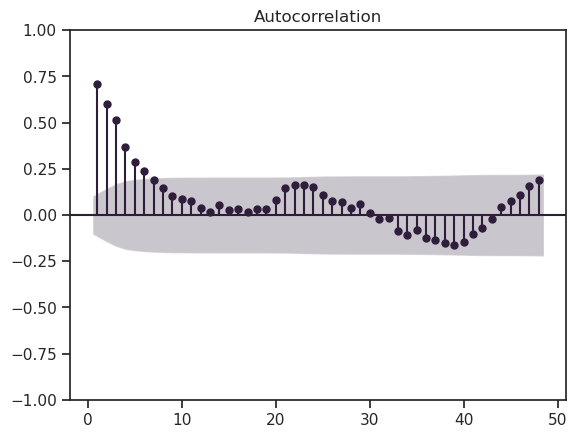

In [56]:
plot_acf(subset["PM 2.5"],
         lags=48,
         zero=False)
plt.show()

In [57]:
# Seasonal ARIMA step-wise grid search
# Test size to forecast missing length onwards
test_size = padding + missing_length

train, test = pm.model_selection.train_test_split(subset["PM 2.5"], test_size=test_size)
print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

Train: (331,)
Test: (30,)


In [58]:
# Seasonal ARIMA model
auto_sarima = pm.auto_arima(train,
                           seasonal=True,
                           m=6,
                           test="adf",
                           stepwise=True,
                           trace=True)

auto_sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=1371.586, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=1607.683, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=1377.539, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=1465.149, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=2011.704, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[6] intercept   : AIC=1369.563, Time=0.28 sec
 ARIMA(2,0,2)(0,0,0)[6] intercept   : AIC=1367.994, Time=0.13 sec
 ARIMA(2,0,2)(1,0,0)[6] intercept   : AIC=1369.582, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[6] intercept   : AIC=1367.667, Time=0.07 sec
 ARIMA(1,0,2)(1,0,0)[6] intercept   : AIC=1369.661, Time=0.16 sec
 ARIMA(1,0,2)(0,0,1)[6] intercept   : AIC=1369.661, Time=0.18 sec
 ARIMA(1,0,2)(1,0,1)[6] intercept   : AIC=1371.549, Time=0.66 sec
 ARIMA(0,0,2)(0,0,0)[6] intercept   : AIC=1433.116, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[6] intercept   : AIC=1367.235, Time=0.05 sec
 ARIMA(1,0,1)(1,0,0)[6] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  331
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -679.454
Date:                Wed, 02 Nov 2022   AIC                           1366.908
Time:                        16:35:03   BIC                           1382.116
Sample:                    11-16-2021   HQIC                          1372.974
                         - 11-29-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9718      0.285      3.414      0.001       0.414       1.530
ar.L1          0.5880      0.034     17.214      0.000       0.521       0.655
ar.L2          0.1871      0.033      5.735      0.000       0.123       0.251
sigma2         3.5435      0.163     21.793      0.000       3.225       3.862
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):               842.81
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
# Forecasting missing interval
forecast = auto_sarima.predict(n_periods=test_size)

print("Original sequence:")
display(subset.loc[forecast.index[:missing_length], "PM 2.5"])
print("Predicted sequence:")
display(forecast[:missing_length])

Original sequence:


2021-11-29 19:00:00    3.419275
2021-11-29 20:00:00    3.786819
2021-11-29 21:00:00    5.062339
2021-11-29 22:00:00    5.050550
2021-11-29 23:00:00    4.529205
2021-11-30 00:00:00    4.198236
Name: PM 2.5, dtype: float64

Predicted sequence:


2021-11-29 19:00:00    3.512422
2021-11-29 20:00:00    3.669273
2021-11-29 21:00:00    3.786545
2021-11-29 22:00:00    3.884850
2021-11-29 23:00:00    3.964598
2021-11-30 00:00:00    4.029884
Freq: H, dtype: float64

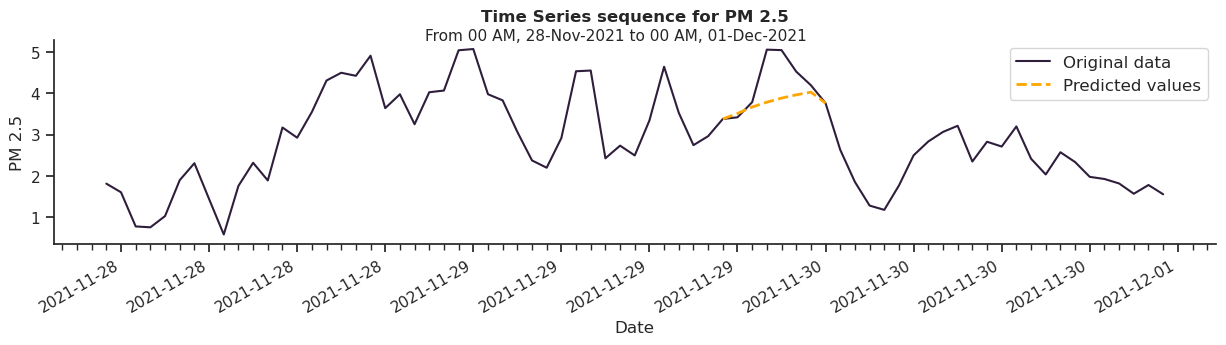

In [60]:
# Visualizing predicted interval
predicted = subset.copy()
predicted.loc[forecast.index[:missing_length], "PM 2.5"] = forecast[:missing_length]

plot_compare(
    predicted,
    subset,
    missing_range=subset_missing,
    start=datetime(2021, 11, 28),
    end=datetime(2021, 12, 1),
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    data_label="Predicted values",
    data_missing_label="Original data",
    figsize=(15, 3),
    fill=False
)

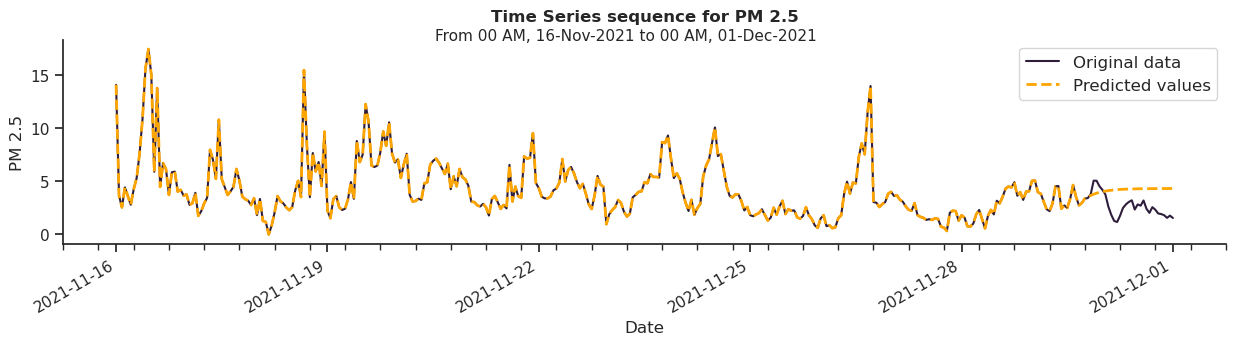

In [61]:
# Visualizing predicted interval over complete test span
predicted = subset.copy()
predicted.loc[forecast.index, "PM 2.5"] = forecast

plot_compare(
    predicted,
    subset,
    # missing_range=subset_missing,
    start=datetime(2021, 11, 15),
    end=datetime(2021, 12, 1),
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=False,
    data_label="Predicted values",
    data_missing_label="Original data",
    figsize=(15, 3),
    fill=False
)

### LSTM on one year data

In [62]:
import tensorflow as tf
from sklearn import preprocessing

np.random.seed(111)
tf.random.set_seed(111)

missing_length = 6
padding = 24
test_size = padding + missing_length

2022-11-02 16:35:03.710587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Original subset contains missing data. Total missing values 68.


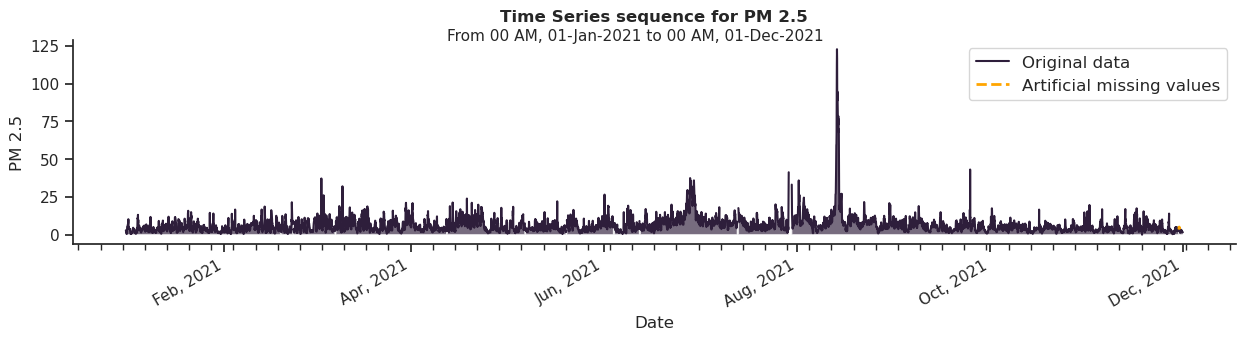

In [63]:
# Experimental subset
station_subset_2021_11 = station_subset[datetime(2021, 1, 1):datetime(2021, 12, 1)]

subset, subset_missing = create_missing(
    data=station_subset_2021_11,
    value="PM 2.5",
    missing_length=missing_length,
    padding=padding,
    missing_index="end",
)
plot_compare(
    subset,
    subset_missing,
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    data_label="Artificial missing values",
    data_missing_label="Original data",
    figsize=(15, 3)
)

In [64]:
test = subset["PM 2.5"].interpolate().tail(test_size)
train = subset["PM 2.5"].interpolate().drop(test.index)
print(test.shape)
print(train.shape)

(30,)
(7987,)


In [65]:
# MinMax Scaler
uni_train = train.values
scaler_x = preprocessing.MinMaxScaler()
x_rescaled = scaler_x.fit_transform(uni_train.reshape(-1, 1))

In [66]:
# Univariate window function
def custom_ts_univariate_data_prep(dataset, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indicesx = range(i-window, i)
        X.append(np.reshape(dataset[indicesx], (window, 1)))
        indicesy = range(i,i+horizon)
        y.append(dataset[indicesy])
    return np.array(X), np.array(y)

In [67]:
univar_hist_window = 48
horizon = 1
TRAIN_SPLIT = 6000

x_train_uni, y_train_uni = custom_ts_univariate_data_prep(x_rescaled, 0, TRAIN_SPLIT,univar_hist_window, horizon)
x_val_uni, y_val_uni = custom_ts_univariate_data_prep(x_rescaled, TRAIN_SPLIT, None,univar_hist_window,horizon)

In [68]:
# Defining TensorFlow DataSets
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

2022-11-02 16:35:07.418609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-02 16:35:07.492393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-02 16:35:07.492812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-02 16:35:07.494694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow wi

In [69]:
# Model path
model_path = "./models/LSTM_Univariate.h5"

In [147]:
# LSTM Model
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100,
        input_shape=x_train_uni.shape[-2:],
        return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])
lstm_model.compile(optimizer='adam', loss='mse')

In [149]:
# Training and early stopping
# EVALUATION_INTERVAL = 100
# EPOCHS = 150
# history = lstm_model.fit(train_univariate,
#                          epochs=EPOCHS,
#                          steps_per_epoch=EVALUATION_INTERVAL,
#                          validation_data=val_univariate,
#                          validation_steps=50,
#                          verbose=1,
#                          callbacks=[tf.keras.callbacks.EarlyStopping(
#                             monitor='val_loss', min_delta=0, patience=10,
#                             verbose=1, mode='min'),
#                                     tf.keras.callbacks.ModelCheckpoint(
#                             model_path, monitor='val_loss',
#                             save_best_only=True, mode='min', verbose=0)]
#                          )

Epoch 1/150


2022-10-27 12:41:32.006528: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-10-27 12:41:32.676216: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 [==============================] - 20s 104ms/step - loss: 0.0012 - val_loss: 4.8152e-04
Epoch 2/150
100/100 [==============================] - 6s 60ms/step - loss: 7.6519e-04 - val_loss: 2.6873e-04
Epoch 3/150
100/100 [==============================] - 6s 60ms/step - loss: 6.2723e-04 - val_loss: 2.5020e-04
Epoch 4/150
100/100 [==============================] - 6s 59ms/step - loss: 5.4233e-04 - val_loss: 2.4403e-04
Epoch 5/150
100/100 [==============================] - 6s 60ms/step - loss: 4.8695e-04 - val_loss: 2.2710e-04
Epoch 6/150
100/100 [==============================] - 6s 59ms/step - loss: 4.6334e-04 - val_loss: 2.3420e-04
Epoch 7/150
100/100 [==============================] - 6s 60ms/step - loss: 3.9760e-04 - val_loss: 2.1200e-04
Epoch 8/150
100/100 [==============================] - 6s 61ms/step - loss: 4.0062e-04 - val_loss: 2.0814e-04
Epoch 9/150
100/100 [==============================] - 6s 57ms/step - loss: 3.6768e-04 - val_loss: 2.2037e-04
Epoch 10/150
100/100 [==

In [70]:
Trained_model = tf.keras.models.load_model(model_path)
Trained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 48, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


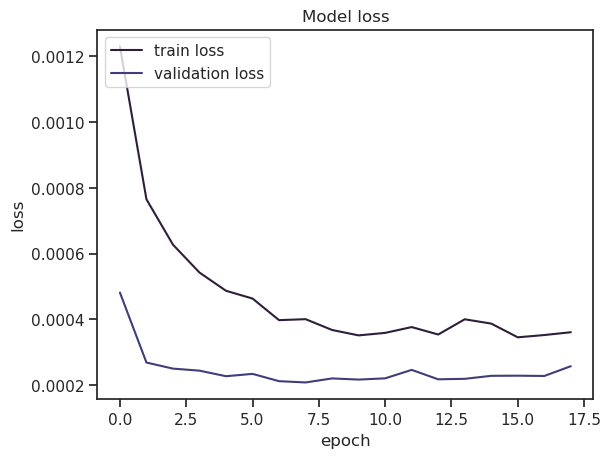

In [151]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train loss', 'validation loss'], loc='upper left')
# plt.rcParams["figure.figsize"] = [16,9]
# plt.show()

In [80]:
# Forecasting with previous 48h values
validatehist = uni_train[-48:]
validatehist
result = []

# Forecast length
window_len = test_size
val_rescaled = scaler_x.transform(validatehist.reshape(-1, 1))

for i in range(1, window_len+1):
    val_rescaled = val_rescaled.reshape((1, val_rescaled.shape[0], 1))
    Predicted_results = Trained_model.predict(val_rescaled)
    print(f"Predicted: {Predicted_results}")

    result.append(Predicted_results[0])
    val_rescaled = np.append(val_rescaled[:,1:],[[Predicted_results]])
    print(val_rescaled)

2022-11-02 17:31:44.920371: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


1/1 [==============================] - 3s 3s/step
Predicted: [[0.02814803]]
[0.01660683 0.01823508 0.01791339 0.01057511 0.0147303  0.01301716
 0.00626757 0.00609208 0.00831823 0.01541994 0.01876995 0.01168569
 0.00467426 0.01428822 0.01885018 0.0153584  0.02583163 0.02381465
 0.02888289 0.03511989 0.03665809 0.03605466 0.04002942 0.02966141
 0.03240356 0.02648586 0.0328055  0.03314179 0.04110539 0.04135091
 0.03241394 0.03120057 0.024971   0.01932135 0.01787903 0.0237481
 0.03695248 0.0370995  0.0197432  0.02224315 0.02030515 0.02722828
 0.03785124 0.02873671 0.02234347 0.02411571 0.02751782 0.02814803]
1/1 [==============================] - 0s 28ms/step
Predicted: [[0.03014314]]
[0.01823508 0.01791339 0.01057511 0.0147303  0.01301716 0.00626757
 0.00609208 0.00831823 0.01541994 0.01876995 0.01168569 0.00467426
 0.01428822 0.01885018 0.0153584  0.02583163 0.02381465 0.02888289
 0.03511989 0.03665809 0.03605466 0.04002942 0.02966141 0.03240356
 0.02648586 0.0328055  0.03314179 0.041105

In [84]:
result_inv_transf = scaler_x.inverse_transform(result)
result_inv_transf

array([[3.45596129],
       [3.70091744],
       [3.89783569],
       [4.05837658],
       [4.18757432],
       [4.2904624 ],
       [4.37207299],
       [4.43689757],
       [4.48863457],
       [4.53017968],
       [4.56373292],
       [4.59095184],
       [4.6130906 ],
       [4.63111428],
       [4.64578442],
       [4.6577194 ],
       [4.667426  ],
       [4.67532548],
       [4.68177048],
       [4.68705098],
       [4.69140711],
       [4.69503233],
       [4.69808171],
       [4.70067645],
       [4.70291123],
       [4.70485694],
       [4.70656893],
       [4.70808744],
       [4.70944405],
       [4.7106616 ]])

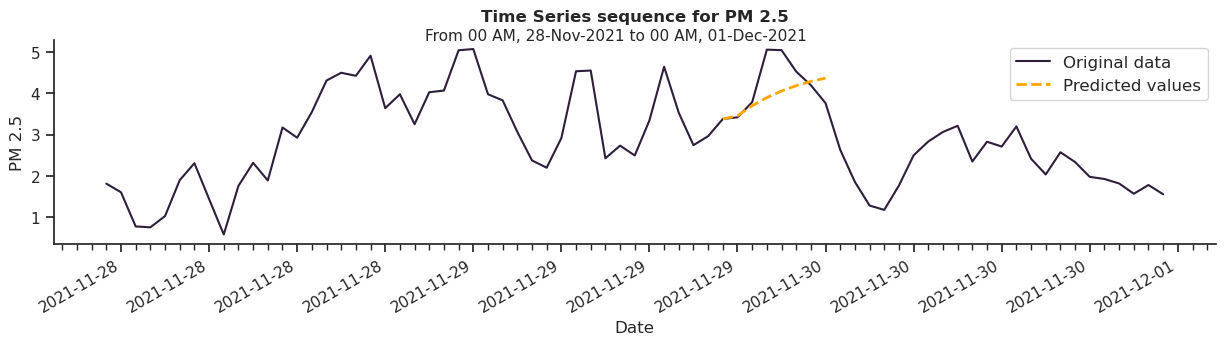

In [106]:
predicted = subset.copy()
predicted.loc[forecast.index, "PM 2.5"] = [i[0] for i in result_inv_transf.tolist()]

plot_compare(
    predicted,
    subset,
    missing_range=subset_missing,
    start=datetime(2021, 11, 28),
    end=datetime(2021, 12, 1),
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=True,
    data_label="Predicted values",
    data_missing_label="Original data",
    figsize=(15, 3),
    fill=False
)

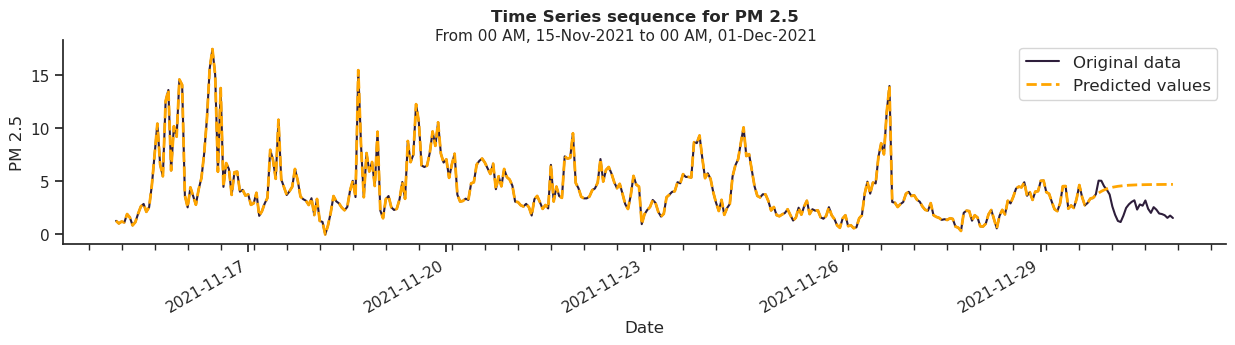

In [105]:
plot_compare(
    predicted,
    subset,
    # missing_range=subset_missing,
    start=datetime(2021, 11, 15),
    end=datetime(2021, 12, 1),
    value="PM 2.5",
    value_missing="PM 2.5",
    missing_only=False,
    data_label="Predicted values",
    data_missing_label="Original data",
    figsize=(15, 3),
    fill=False
)

In [109]:
predicted[-missing_length:]

,STATION,PM 2.5,MISSING,MISSING_SEQ,MISSING_SAMPLE
DATE_PST,,,,,
2021-11-30 19:00:00,North_Vancouver_Second_Narrows_PM25,4.702911,0,0,0
2021-11-30 20:00:00,North_Vancouver_Second_Narrows_PM25,4.704857,0,0,0
2021-11-30 21:00:00,North_Vancouver_Second_Narrows_PM25,4.706569,0,0,0
2021-11-30 22:00:00,North_Vancouver_Second_Narrows_PM25,4.708087,0,0,0
2021-11-30 23:00:00,North_Vancouver_Second_Narrows_PM25,4.709444,0,0,0
2021-12-01 00:00:00,North_Vancouver_Second_Narrows_PM25,4.710662,0,0,0
